In [49]:
import torch.nn.functional as F
from torch import optim
from forestFire import ForestFire
from torch import nn
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from actor_critic import ActorCritic
from helper_functions import plot_train_rewards, plot_test_rewards
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

## Setup replay memory object

In [50]:
class ReplayMemory:
    def __init__(self, size):
        self.buffer = []
        self.max_size = size
        self.oldest_transition = 0

    def sample(self, mb):
        return random.sample(self.buffer, mb)

    def new_transition(self, s, a, r, s_p):
        data = [s, a, r, s_p]
        # Check if buffer is full
        if len(self.buffer) == self.max_size:
            # Replace oldest value in the buffer
            self.buffer[self.oldest_transition] = data
            self.oldest_transition += 1
            if self.oldest_transition == self.max_size:
                self.oldest_transition = 0
        else:
            # Append to the end of buffer
            self.buffer.append(data)

# Create Neural Network for DQN

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ForestFireDQN(nn.Module):
    def __init__(self, input_size):
        super(ForestFireDQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=32),
            nn.ReLU(True),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(True),
            nn.Linear(in_features=256, out_features=4),
        )


    def forward(self, x):
        x.to(device)
        return self.network(x)

# DQN

## Training DQN on the simple environment

Mean reward after episode 100: -29.5
Mean reward after episode 200: -2.8
Mean reward after episode 300: 8.6
Mean reward after episode 400: 15.8
Mean reward after episode 500: 27.2
Mean reward after episode 600: 26.2
Mean reward after episode 700: 20.5
Mean reward after episode 800: 32.3
Mean reward after episode 900: 27.4
Mean reward after episode 1000: 24.4


<Figure size 640x480 with 0 Axes>

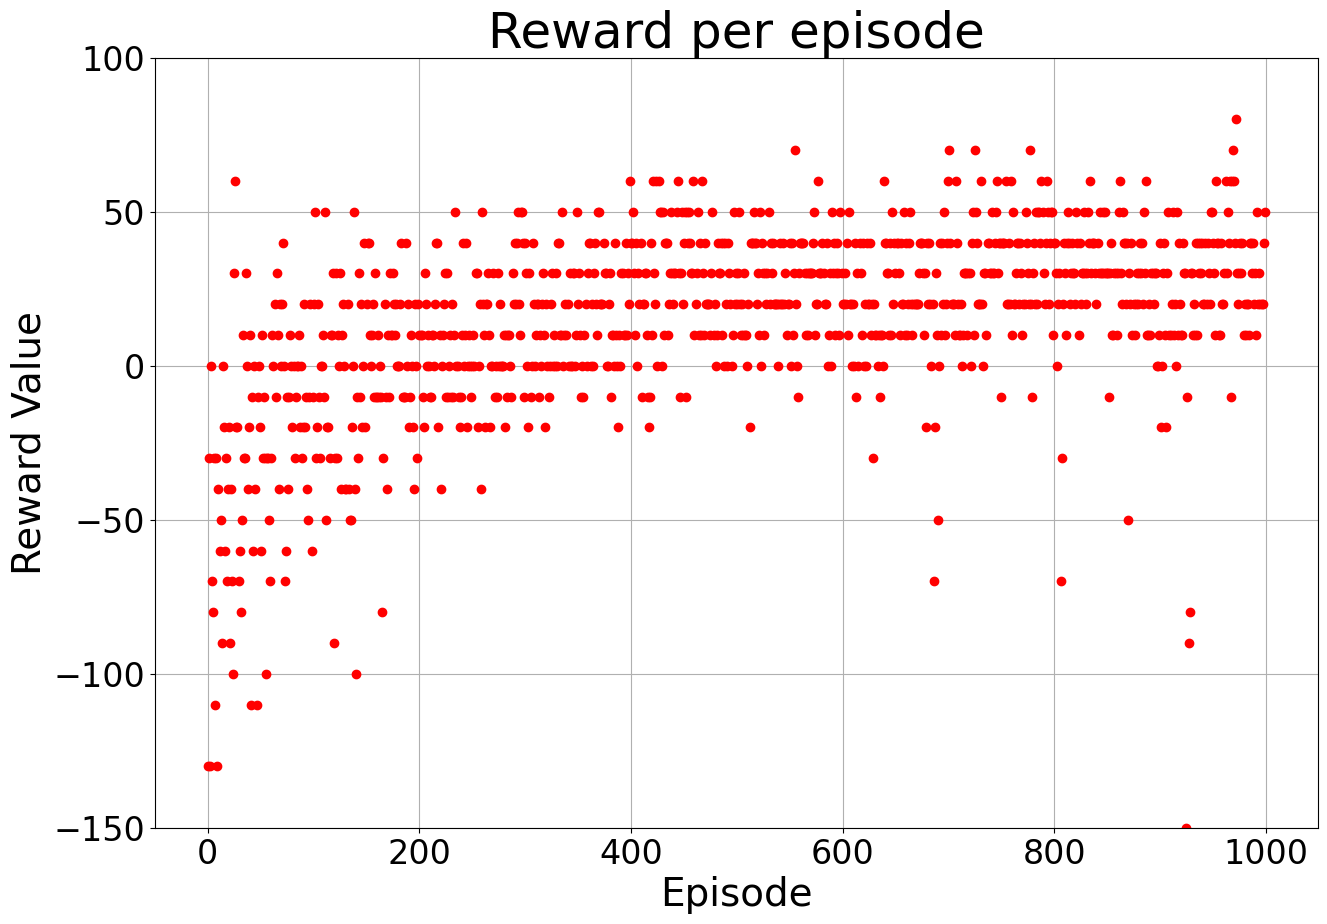

In [52]:
# Defining Constants
max_episodes = 1000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, random_fire=False)

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(8)
target_policy = ForestFireDQN(8)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
simple_dqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets).to(torch.float32)
            estimations_s = torch.stack(estimations).to(torch.float32)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    simple_dqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(simple_dqn_total_rewards[-100:]).mean()}')

plot_train_rewards(environment_name='Simple', algorithm_name='DQN', episodic_rewards=simple_dqn_total_rewards, ymin=-150, ymax=100, show=True)

# Testing DQN on the simple environment

<Figure size 640x480 with 0 Axes>

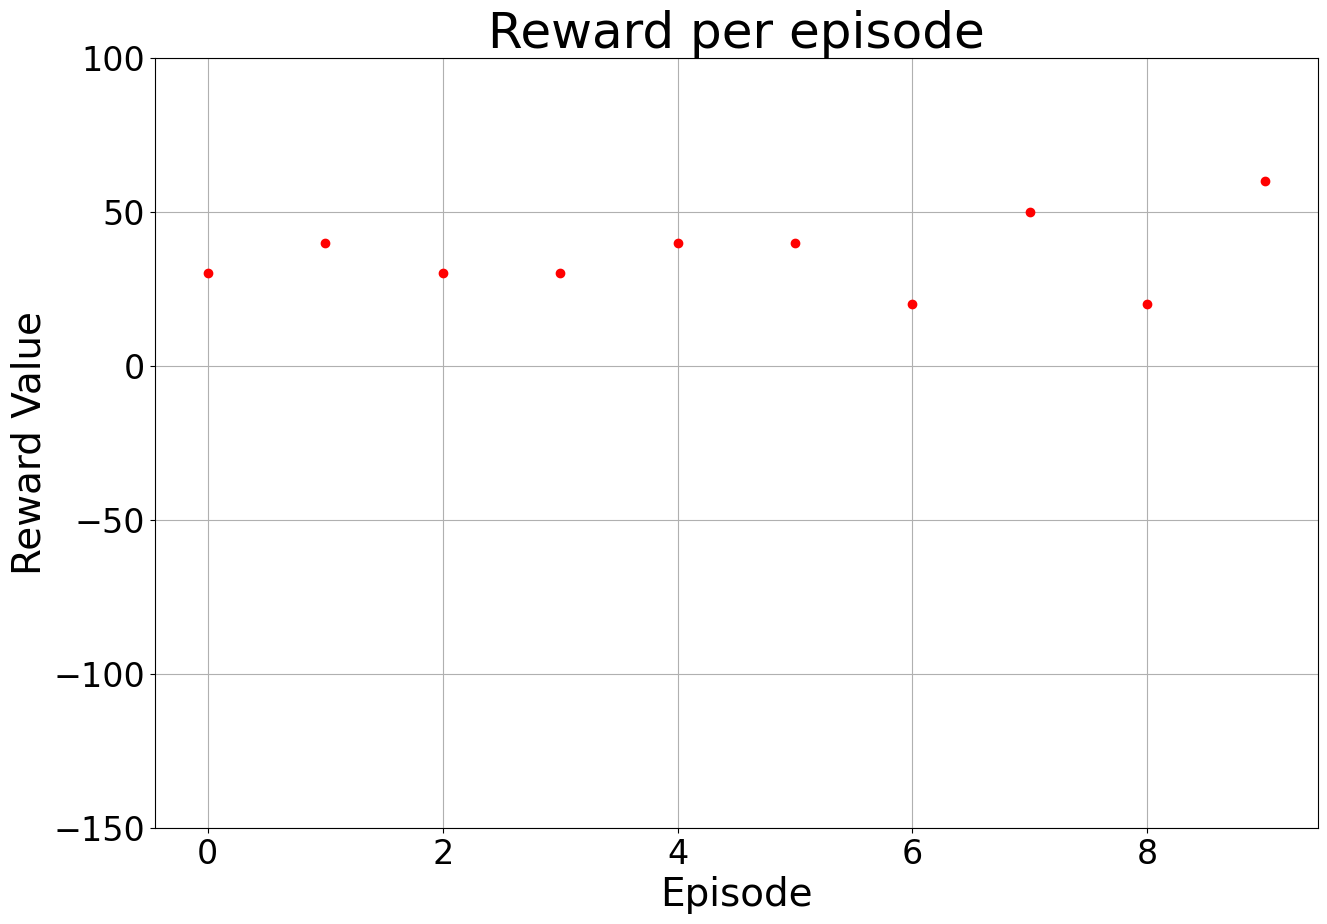

<Figure size 640x480 with 0 Axes>

In [54]:
environment_name = 'forest_fire'
algorithm_name = 'Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
simple_dqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
            render = test_env.render(plot=False)

    simple_dqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, simple_dqn_test_rewards, min_reward, max_reward, show=True)

## Training DQN on the complex environment


Mean reward after episode 100: -10.5
Mean reward after episode 200: 11.3
Mean reward after episode 300: 30.6
Mean reward after episode 400: 41.1
Mean reward after episode 500: 45.2
Mean reward after episode 600: 47.8
Mean reward after episode 700: 54.0
Mean reward after episode 800: 54.6
Mean reward after episode 900: 54.4
Mean reward after episode 1000: 52.5


<Figure size 640x480 with 0 Axes>

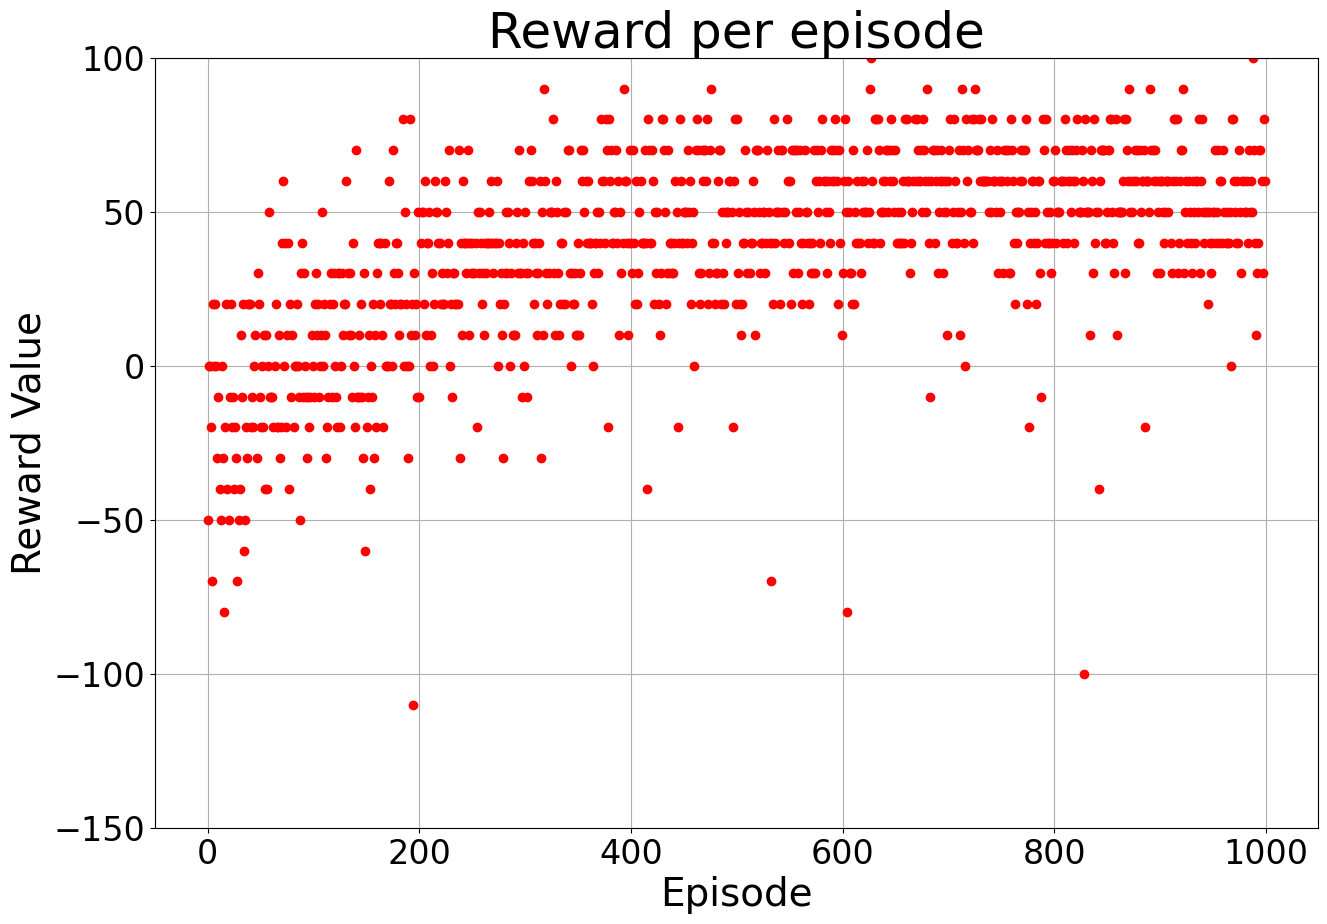

In [55]:
# Defining Constants
max_episodes = 1000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
complex_dqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets).to(torch.float32)
            estimations_s = torch.stack(estimations).to(torch.float32)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    complex_dqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(complex_dqn_total_rewards[-100:]).mean()}')

plot_train_rewards(environment_name='Complex', algorithm_name='DQN', episodic_rewards=complex_dqn_total_rewards, ymin=-150, ymax=100, show=True)

## Test DQN on the complex environment

<Figure size 640x480 with 0 Axes>

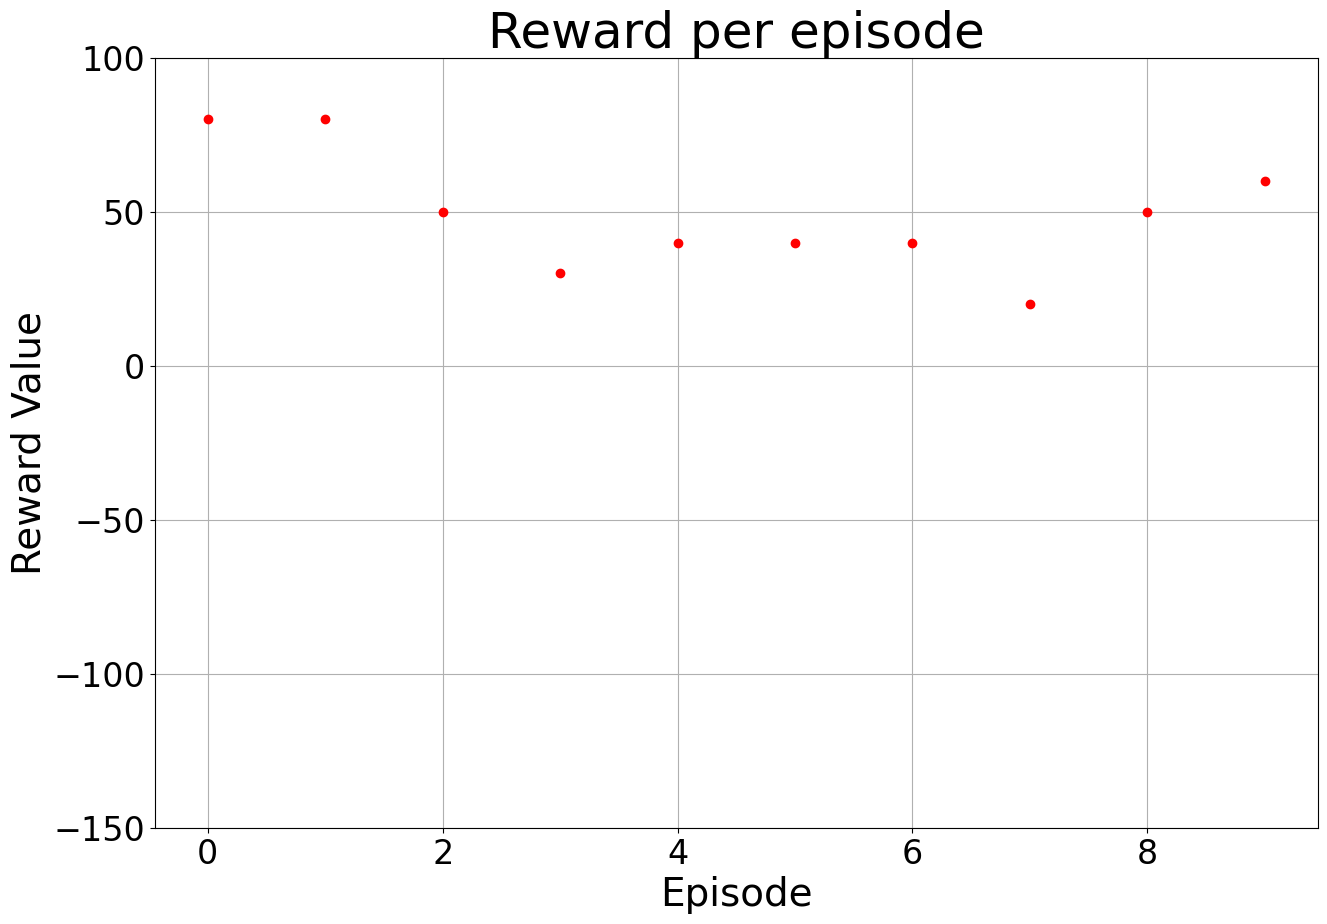

<Figure size 640x480 with 0 Axes>

In [56]:
environment_name = 'forest_fire'
algorithm_name = 'Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
test_rewards = []
test_env = ForestFire(10, 10, obs_type='complex', save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
            render = test_env.render(plot=False)

    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

## Training DQN on a 10x10 grid and testing on a 15x15 grid


Mean reward after episode 100: -17.6
Mean reward after episode 200: 16.4
Mean reward after episode 300: 32.0
Mean reward after episode 400: 42.5
Mean reward after episode 500: 50.3
Mean reward after episode 600: 51.3
Mean reward after episode 700: 48.0
Mean reward after episode 800: 52.7
Mean reward after episode 900: 50.0
Mean reward after episode 1000: 49.6


<Figure size 640x480 with 0 Axes>

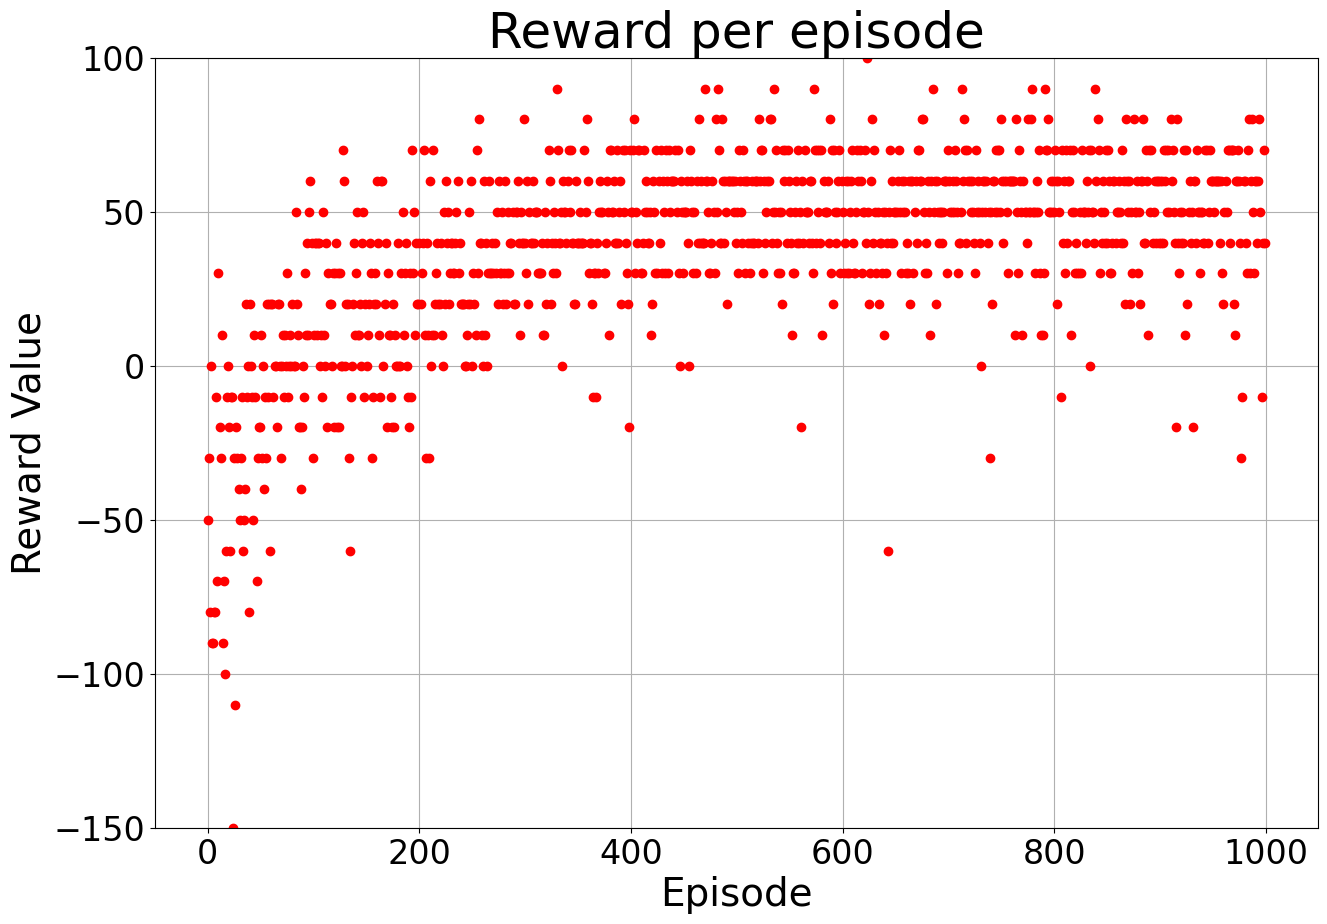

In [57]:
# Defining Constants
max_episodes = 1000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
ten_complex_dqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets).to(torch.float32)
            estimations_s = torch.stack(estimations).to(torch.float32)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    ten_complex_dqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(ten_complex_dqn_total_rewards[-100:]).mean()}')

plot_train_rewards(environment_name='Complex Ten', algorithm_name='DQN', episodic_rewards=ten_complex_dqn_total_rewards, ymin=-150, ymax=100, show=True)

<Figure size 640x480 with 0 Axes>

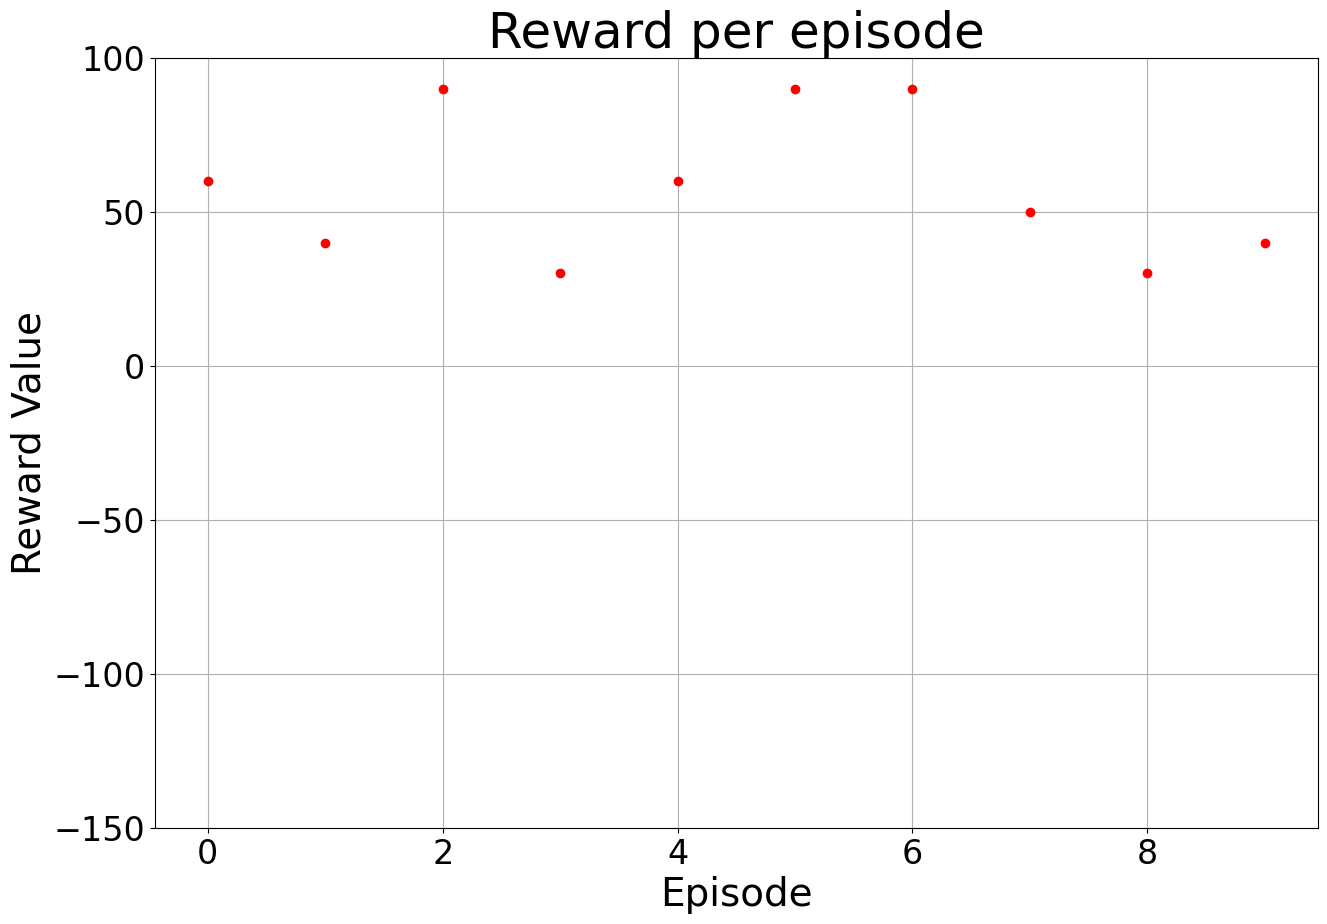

<Figure size 640x480 with 0 Axes>

In [59]:
environment_name = 'forest_fire'
algorithm_name = 'Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
fifteen_complex_dqn_test_rewards = []
test_env = ForestFire(15, 15, save_results=True, obs_type='complex')
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
            render = test_env.render(plot=False)

    fifteen_complex_dqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, fifteen_complex_dqn_test_rewards, min_reward, max_reward, show=True)

## Training DQN on a 15x15 grid and testing on a 10x10 grid


Mean reward after episode 100: -28.2
Mean reward after episode 200: 13.0
Mean reward after episode 300: 36.4
Mean reward after episode 400: 40.4
Mean reward after episode 500: 41.7
Mean reward after episode 600: 36.9
Mean reward after episode 700: 47.2
Mean reward after episode 800: 50.1
Mean reward after episode 900: 55.7
Mean reward after episode 1000: 66.0


<Figure size 640x480 with 0 Axes>

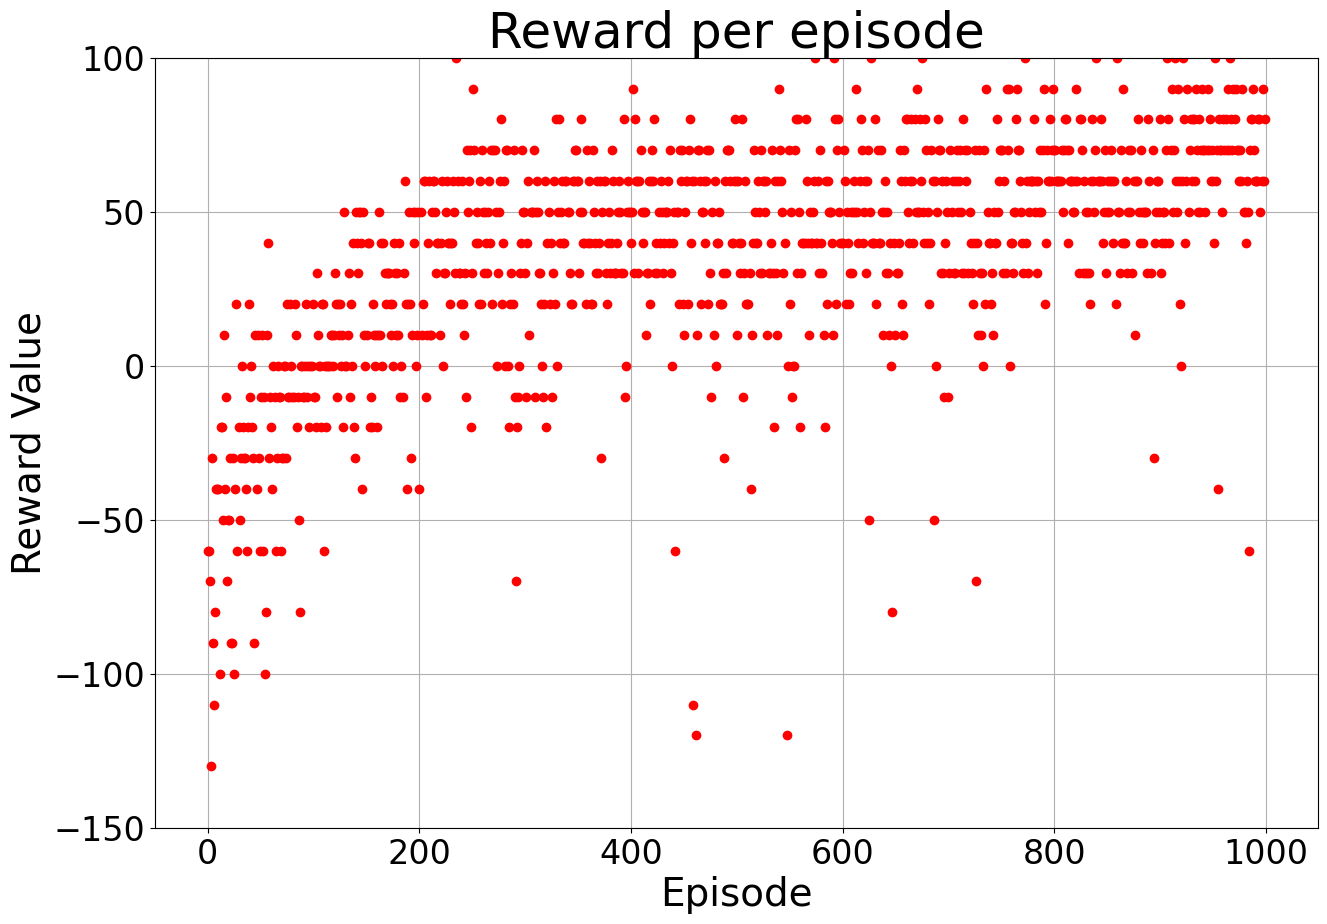

In [61]:
# Defining Constants
max_episodes = 1000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=15, width=15, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
fifteen_complex_dqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets).to(torch.float32)
            estimations_s = torch.stack(estimations).to(torch.float32)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    fifteen_complex_dqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(fifteen_complex_dqn_total_rewards[-100:]).mean()}')

plot_train_rewards(environment_name='Complex Fifteen', algorithm_name='DQN', episodic_rewards=fifteen_complex_dqn_total_rewards, ymin=-150, ymax=100, show=True)

<Figure size 640x480 with 0 Axes>

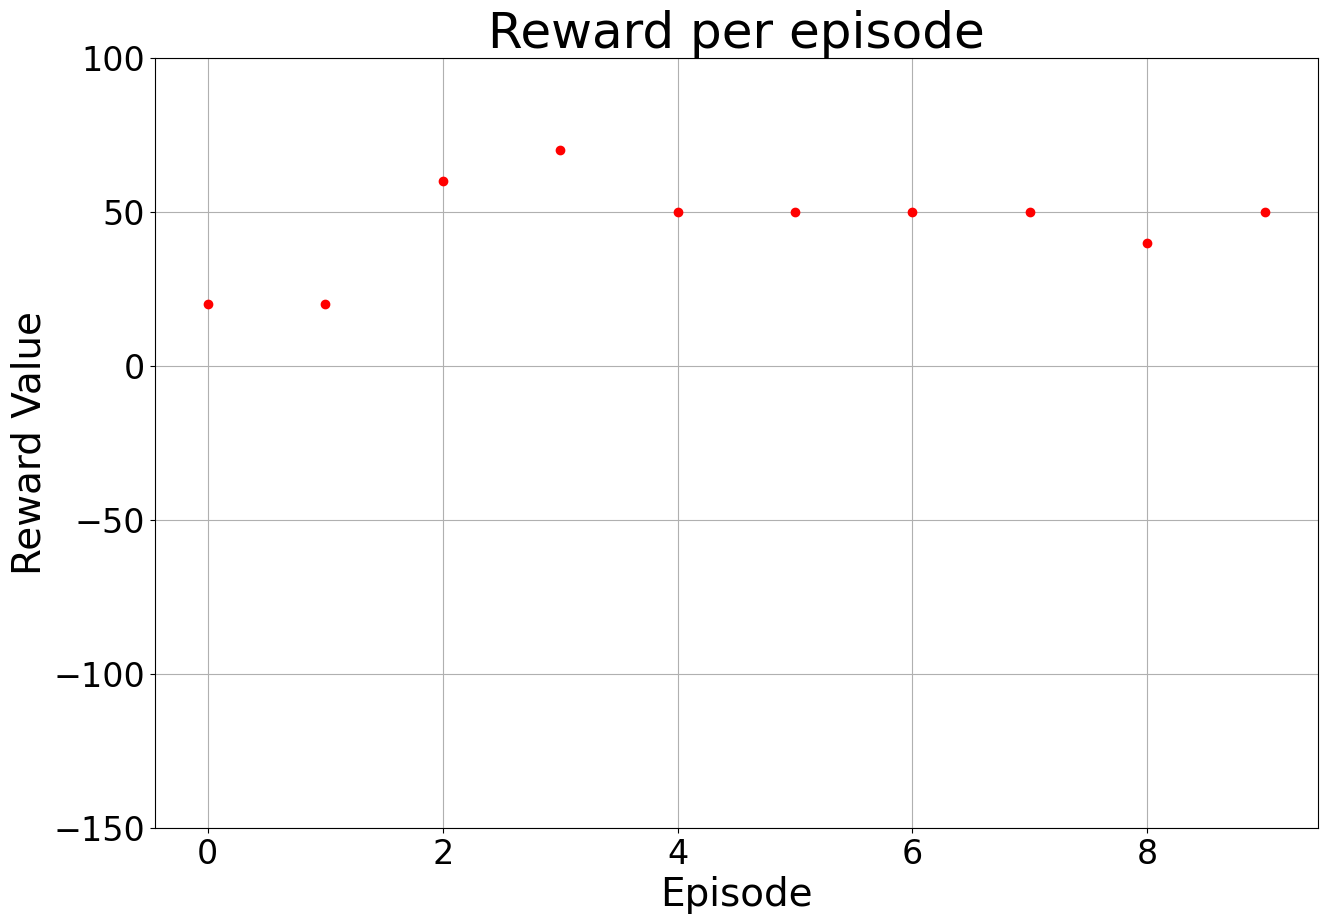

<Figure size 640x480 with 0 Axes>

In [62]:
environment_name = 'forest_fire'
algorithm_name = 'Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
ten_complex_dqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True, obs_type='complex')
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
            render = test_env.render(plot=False)

    ten_complex_dqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, ten_complex_dqn_test_rewards, min_reward, max_reward, show=True)

## Training DQN on the complex environment with random fire


Mean reward after episode 100: -29.4
Mean reward after episode 200: -3.8
Mean reward after episode 300: 17.6
Mean reward after episode 400: 24.4
Mean reward after episode 500: 32.6
Mean reward after episode 600: 43.8
Mean reward after episode 700: 43.3
Mean reward after episode 800: 42.5
Mean reward after episode 900: 46.8
Mean reward after episode 1000: 49.4


<Figure size 640x480 with 0 Axes>

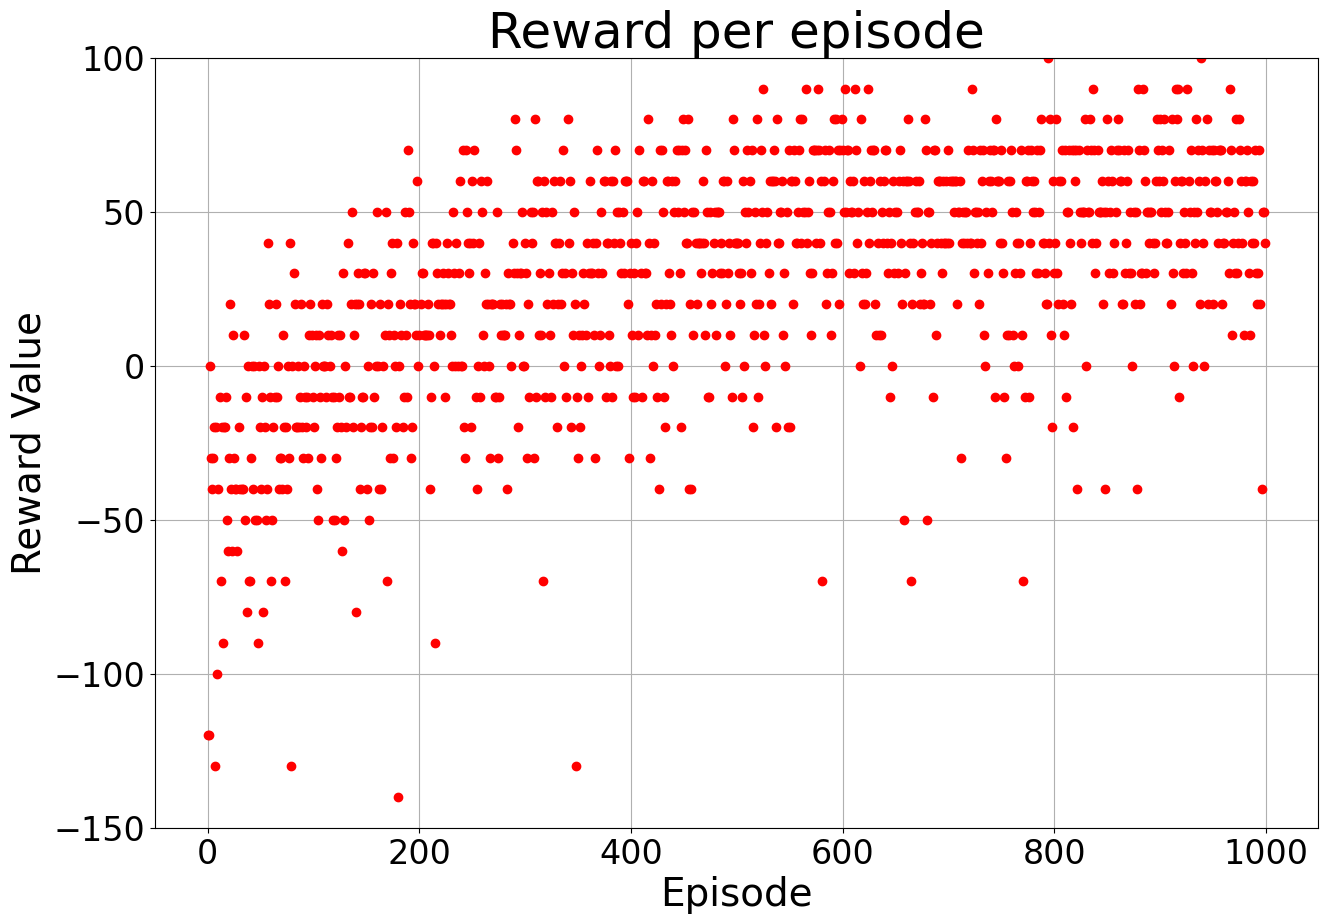

In [63]:
# Defining Constants
max_episodes = 1000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex', random_fire=True)

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
random_fire_dqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets).to(torch.float32)
            estimations_s = torch.stack(estimations).to(torch.float32)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    random_fire_dqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(random_fire_dqn_total_rewards[-100:]).mean()}')

plot_train_rewards(environment_name='Complex Random Fire', algorithm_name='DQN', episodic_rewards=random_fire_dqn_total_rewards, ymin=-150, ymax=100, show=True)

<Figure size 640x480 with 0 Axes>

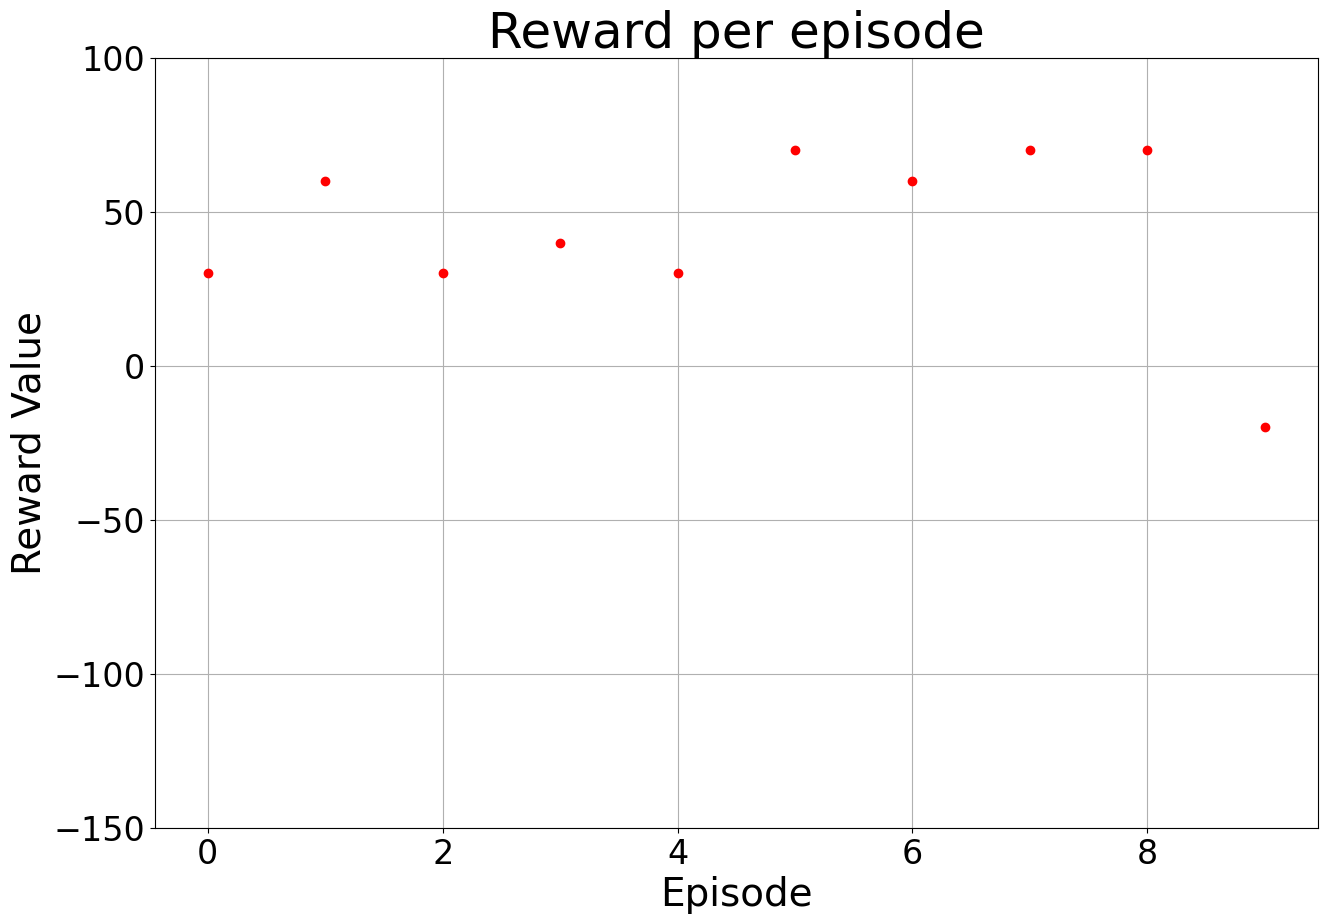

<Figure size 640x480 with 0 Axes>

In [64]:
environment_name = 'forest_fire'
algorithm_name = 'Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
random_fire_dqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True, obs_type='complex', random_fire=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
            render = test_env.render(plot=False)

    random_fire_dqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, random_fire_dqn_test_rewards, min_reward, max_reward, show=True)

# Double DQN

## Train Double DQN on simple environment

Mean reward after episode 100: -50.3
Mean reward after episode 200: -30.4
Mean reward after episode 300: -28.7
Mean reward after episode 400: -25.9
Mean reward after episode 500: -19.9
Mean reward after episode 600: -9.8
Mean reward after episode 700: -10.5
Mean reward after episode 800: -16.5
Mean reward after episode 900: -0.5
Mean reward after episode 1000: -0.1
Mean reward after episode 1100: -1.7
Mean reward after episode 1200: 4.3
Mean reward after episode 1300: 3.4
Mean reward after episode 1400: -0.7
Mean reward after episode 1500: 0.0
Mean reward after episode 1600: 9.7
Mean reward after episode 1700: 6.1
Mean reward after episode 1800: 12.8
Mean reward after episode 1900: 5.3
Mean reward after episode 2000: 1.4
Mean reward after episode 2100: 2.3
Mean reward after episode 2200: -19.0
Mean reward after episode 2300: 13.6
Mean reward after episode 2400: 11.5
Mean reward after episode 2500: 16.6
Mean reward after episode 2600: 12.9
Mean reward after episode 2700: 19.1
Mean rewar

<Figure size 640x480 with 0 Axes>

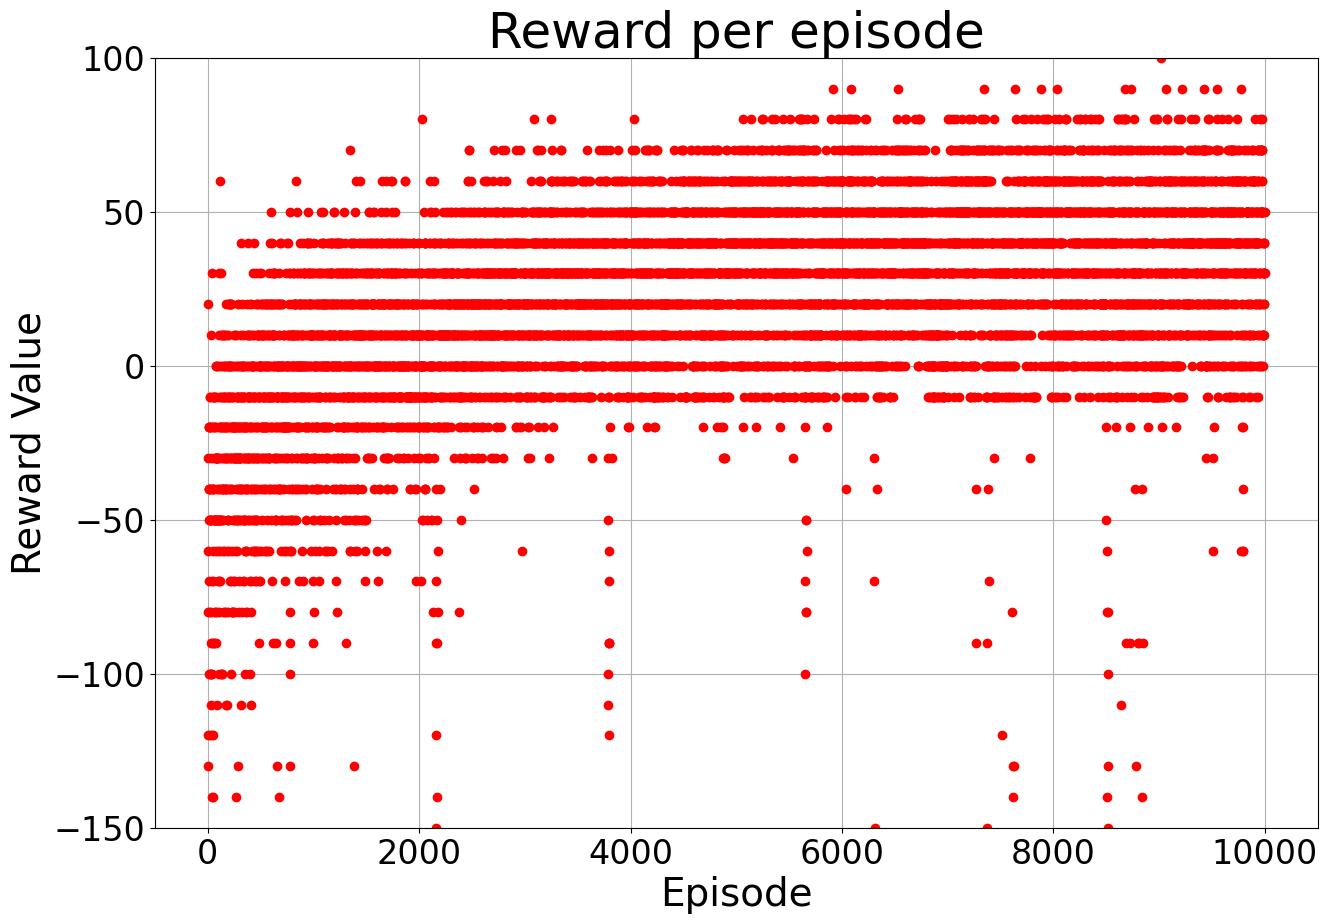

In [65]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10)

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(8)
target_policy = ForestFireDQN(8)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
simple_ddqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = torch.Tensor(transition[3])
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
                primary_theta = list(main_policy.parameters())[i].clone()
                primary_theta = torch.multiply(primary_theta, tau)
                target_theta = list(target_policy.parameters())[i].clone()
                target_theta = torch.multiply(target_theta, (1 - tau))
                list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    simple_ddqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(simple_ddqn_total_rewards[-100:]).mean()}')
    # End Training

plot_train_rewards(environment_name='Simple', algorithm_name='Double DQN', episodic_rewards=simple_ddqn_total_rewards, ymin=-150, ymax=100, show=True)

## Test Double DQN on simple environment

<Figure size 640x480 with 0 Axes>

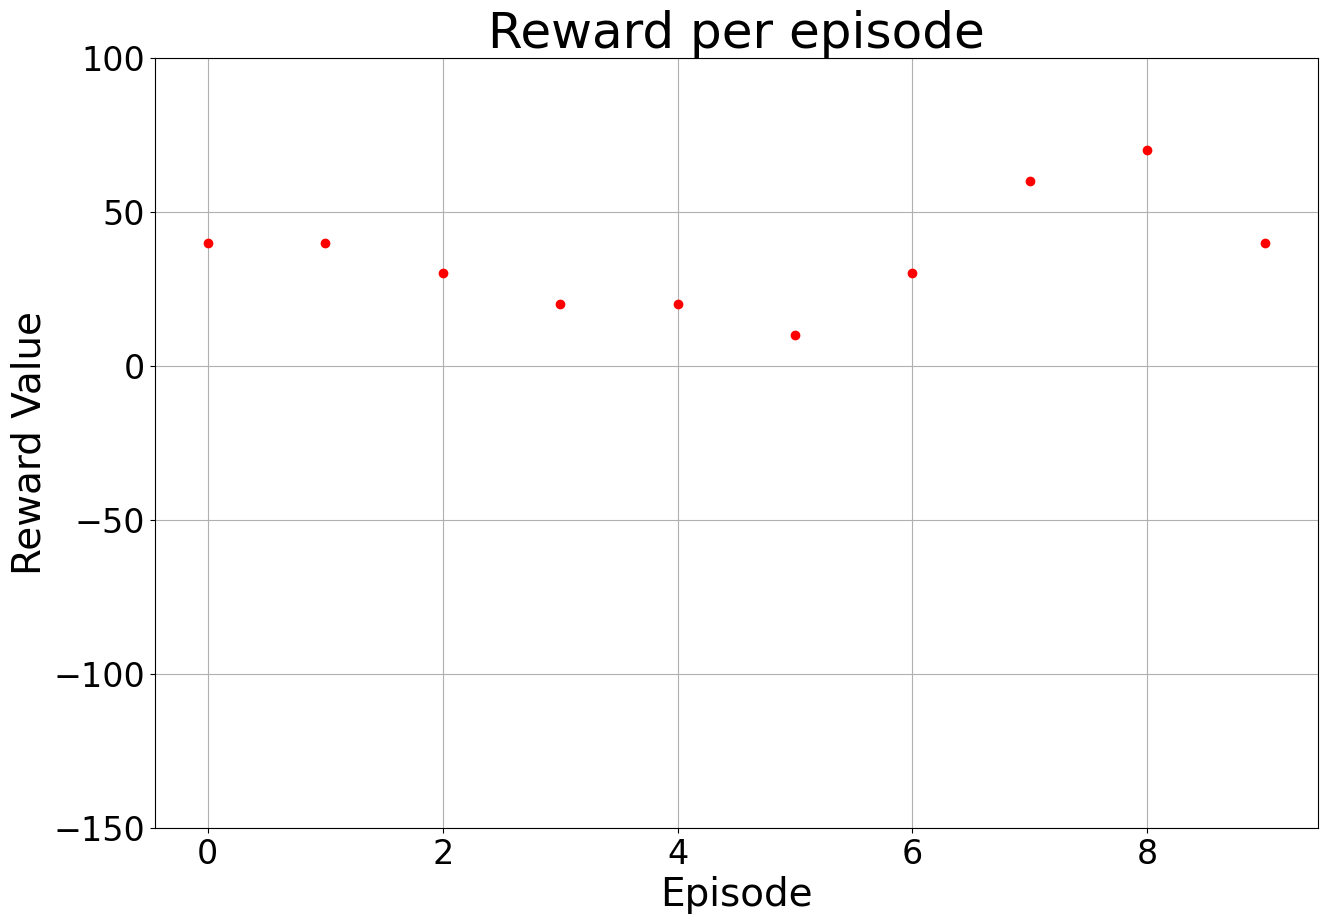

<Figure size 640x480 with 0 Axes>

In [66]:
environment_name = 'forest_fire'
algorithm_name = 'Dobule-Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
simple_ddqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs

    simple_ddqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, simple_ddqn_test_rewards, min_reward, max_reward, show=True)

## Train Double DQN on complex environment

Mean reward after episode 100: -40.3
Mean reward after episode 200: -39.5
Mean reward after episode 300: -29.1
Mean reward after episode 400: -27.2
Mean reward after episode 500: -18.0
Mean reward after episode 600: -17.4
Mean reward after episode 700: -11.0
Mean reward after episode 800: -11.3
Mean reward after episode 900: -2.4
Mean reward after episode 1000: -0.4
Mean reward after episode 1100: 8.7
Mean reward after episode 1200: 9.7
Mean reward after episode 1300: 16.4
Mean reward after episode 1400: 14.7
Mean reward after episode 1500: 14.2
Mean reward after episode 1600: 7.3
Mean reward after episode 1700: 17.3
Mean reward after episode 1800: 12.4
Mean reward after episode 1900: 21.2
Mean reward after episode 2000: 18.0
Mean reward after episode 2100: 9.4
Mean reward after episode 2200: 14.7
Mean reward after episode 2300: 15.2
Mean reward after episode 2400: 12.2
Mean reward after episode 2500: 16.6
Mean reward after episode 2600: 25.3
Mean reward after episode 2700: 31.9
Mean r

<Figure size 640x480 with 0 Axes>

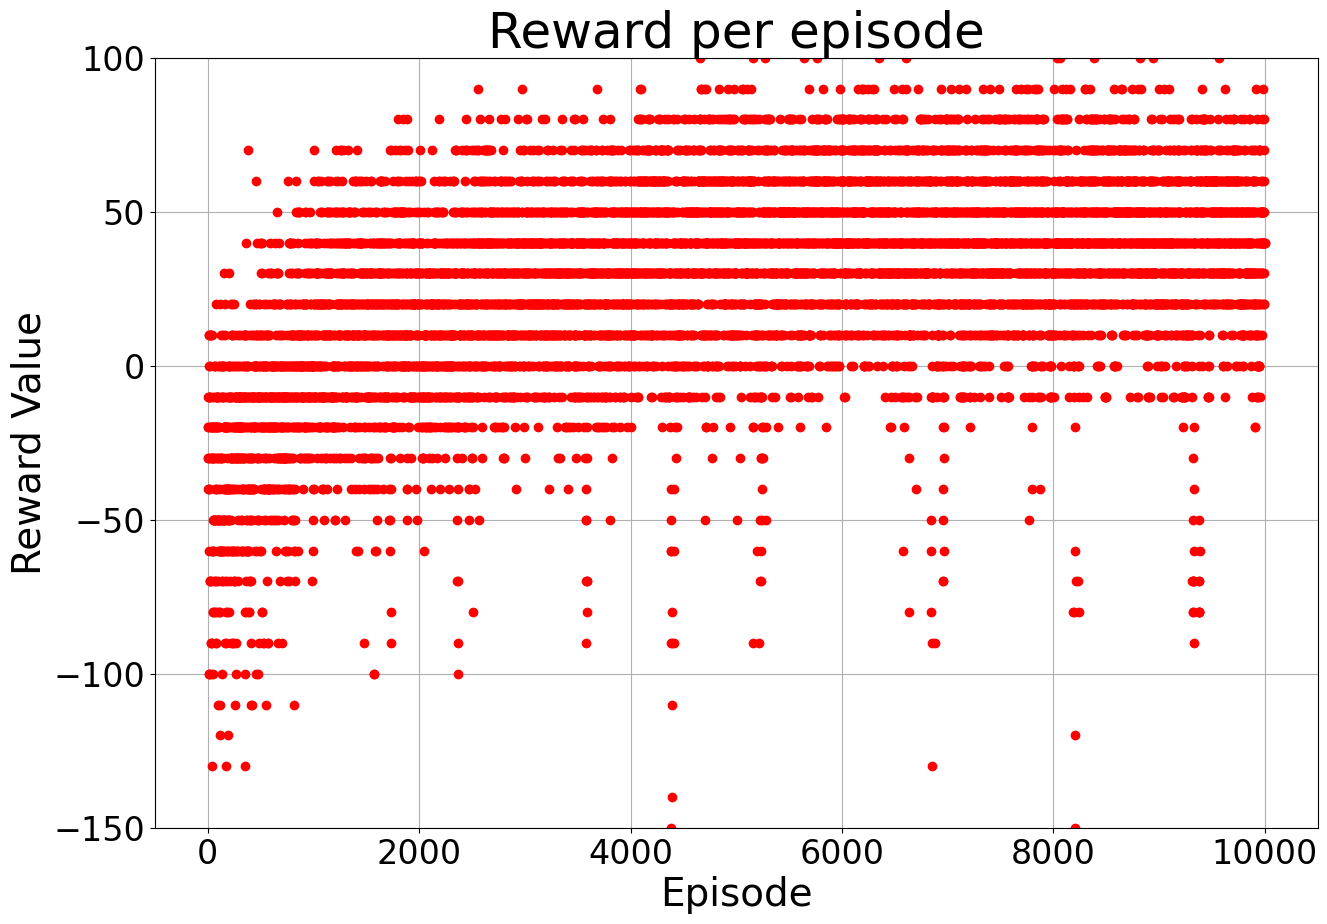

In [67]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
complex_ddqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = torch.Tensor(transition[3])
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
              primary_theta = list(main_policy.parameters())[i].clone()
              primary_theta = torch.multiply(primary_theta, tau)
              target_theta = list(target_policy.parameters())[i].clone()
              target_theta = torch.multiply(target_theta, (1 - tau))
              list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    complex_ddqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(complex_ddqn_total_rewards[-100:]).mean()}')
    # End Training

plot_train_rewards(environment_name='Complex', algorithm_name='Double DQN', episodic_rewards=complex_ddqn_total_rewards, ymin=-150, ymax=100, show=True)

## Test Double DQN on complex environment

<Figure size 640x480 with 0 Axes>

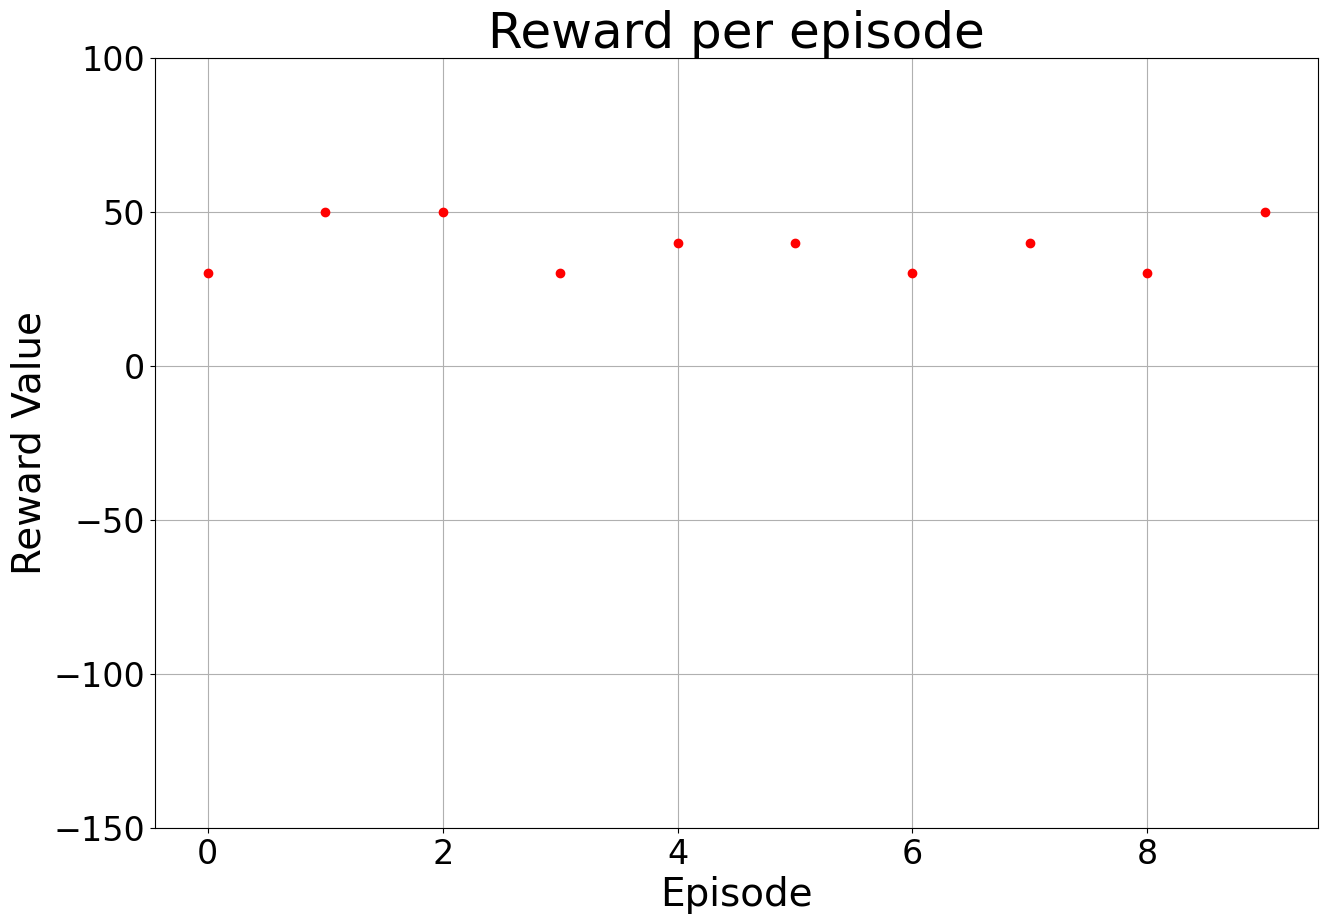

<Figure size 640x480 with 0 Axes>

In [68]:
environment_name = 'forest_fire'
algorithm_name = 'Dobule-Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
complex_ddqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True, obs_type='complex')
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs

    complex_ddqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, complex_ddqn_test_rewards, min_reward, max_reward, show=True)

## Training the agent on 10x10 grid and testing on 15x15 grid

Mean reward after episode 100: -44.9
Mean reward after episode 200: -41.4
Mean reward after episode 300: -32.1
Mean reward after episode 400: -25.1
Mean reward after episode 500: -18.0
Mean reward after episode 600: -17.9
Mean reward after episode 700: -20.4
Mean reward after episode 800: 0.7
Mean reward after episode 900: 4.1
Mean reward after episode 1000: 4.4
Mean reward after episode 1100: -16.9
Mean reward after episode 1200: 4.6
Mean reward after episode 1300: -1.4
Mean reward after episode 1400: 8.5
Mean reward after episode 1500: 0.6
Mean reward after episode 1600: 20.1
Mean reward after episode 1700: 17.1
Mean reward after episode 1800: 13.2
Mean reward after episode 1900: 24.1
Mean reward after episode 2000: 16.3
Mean reward after episode 2100: 7.2
Mean reward after episode 2200: 14.8
Mean reward after episode 2300: 13.7
Mean reward after episode 2400: 16.9
Mean reward after episode 2500: 17.9
Mean reward after episode 2600: 19.8
Mean reward after episode 2700: 19.0
Mean rewa

<Figure size 640x480 with 0 Axes>

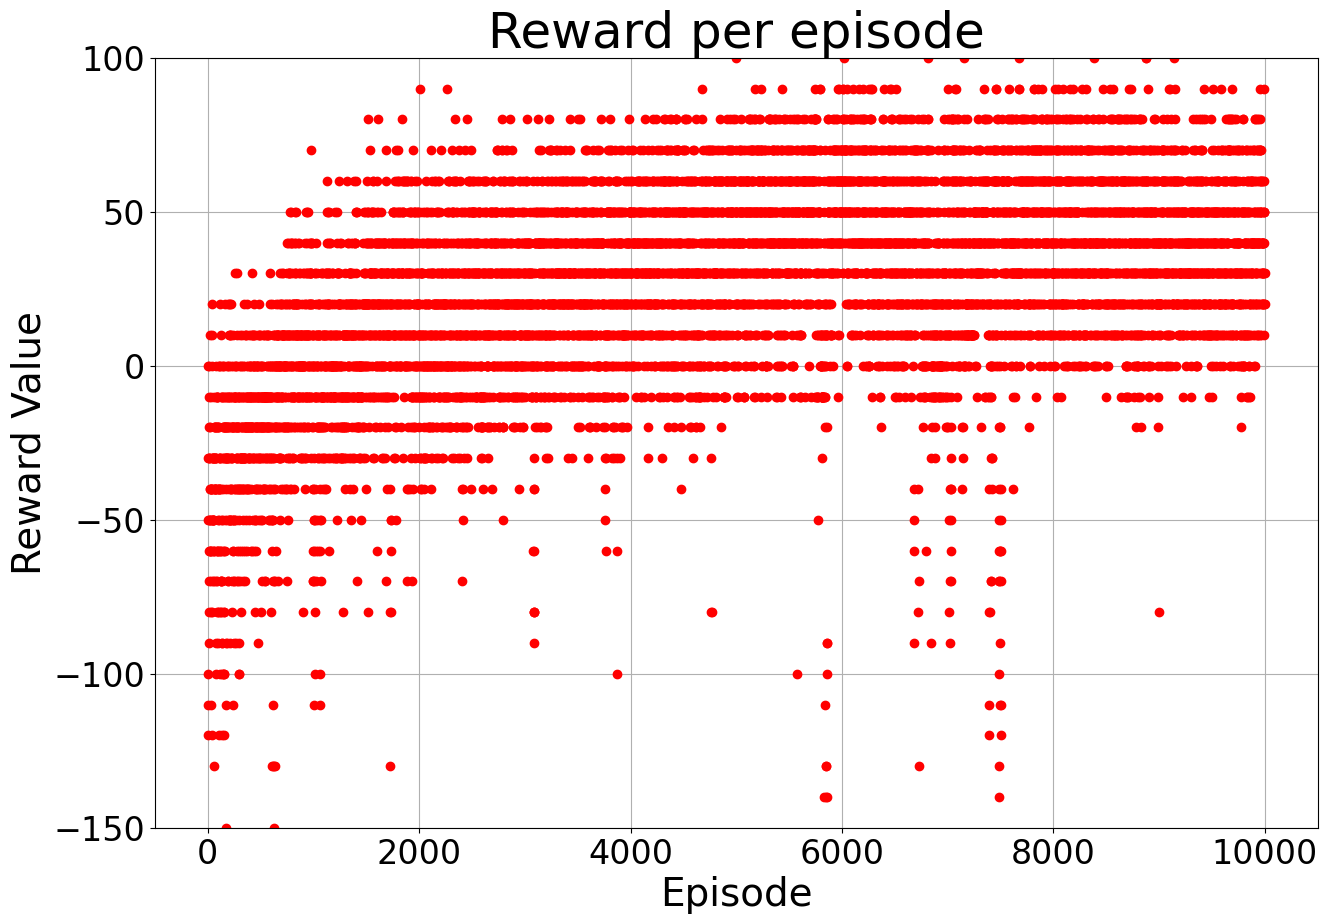

In [69]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
ten_complex_ddqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = torch.Tensor(transition[3])
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
              primary_theta = list(main_policy.parameters())[i].clone()
              primary_theta = torch.multiply(primary_theta, tau)
              target_theta = list(target_policy.parameters())[i].clone()
              target_theta = torch.multiply(target_theta, (1 - tau))
              list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    ten_complex_ddqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(ten_complex_ddqn_total_rewards[-100:]).mean()}')
    # End Training

plot_train_rewards(environment_name='Ten Complex', algorithm_name='Double DQN', episodic_rewards=ten_complex_ddqn_total_rewards, ymin=-150, ymax=100, show=True)

<Figure size 640x480 with 0 Axes>

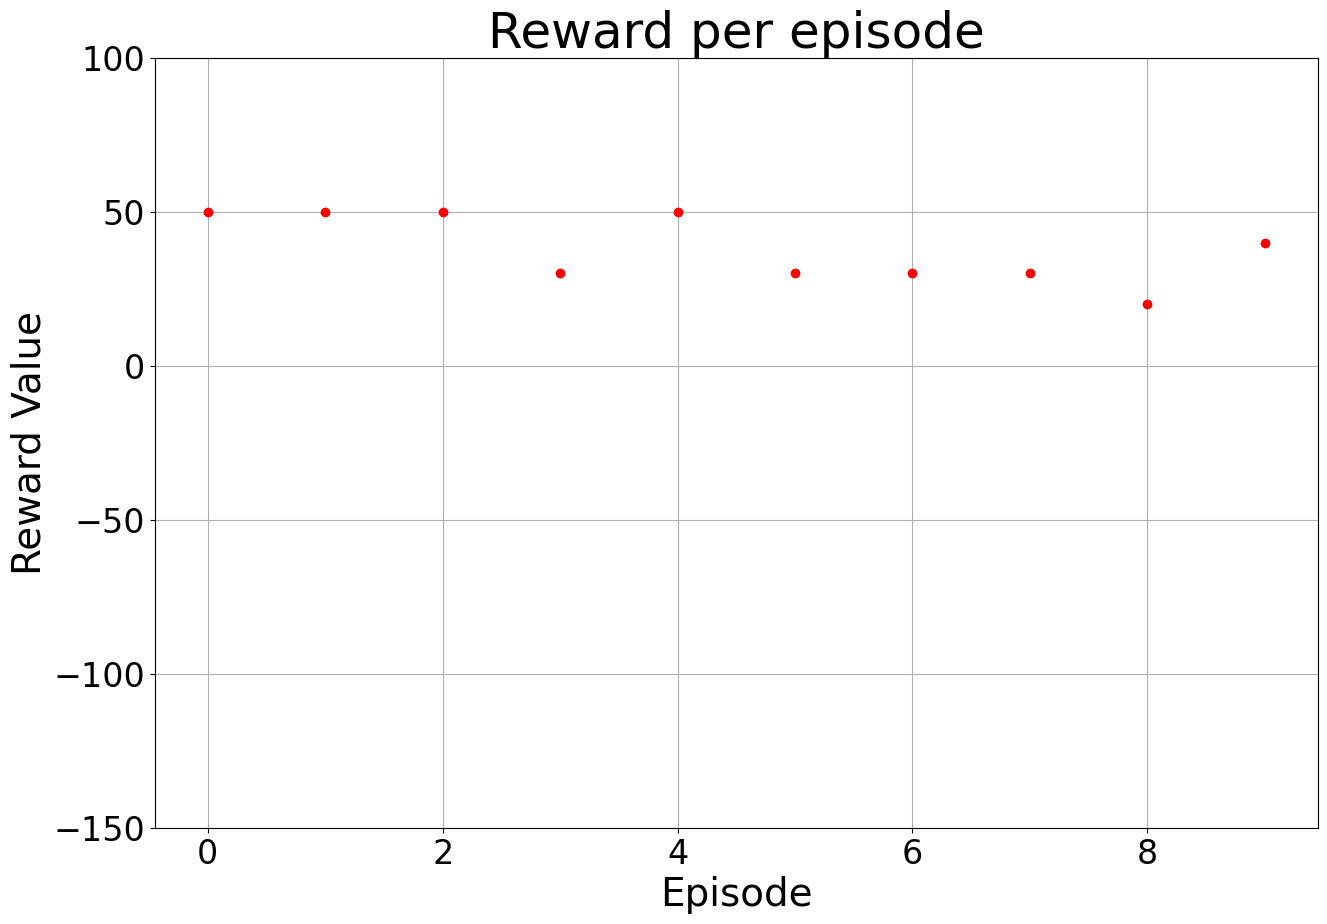

<Figure size 640x480 with 0 Axes>

In [70]:
environment_name = 'forest_fire'
algorithm_name = 'Dobule-Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
fifteen_complex_ddqn_test_rewards = []
test_env = ForestFire(15, 15, save_results=True, obs_type='complex')
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs

    fifteen_complex_ddqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, fifteen_complex_ddqn_test_rewards, min_reward, max_reward, show=True)

## Training the agent on 15x15 grid and testing on 10x10 grid

Mean reward after episode 100: -49.5
Mean reward after episode 200: -52.2
Mean reward after episode 300: -41.7
Mean reward after episode 400: -25.5
Mean reward after episode 500: -31.0
Mean reward after episode 600: -14.8
Mean reward after episode 700: -22.9
Mean reward after episode 800: -13.9
Mean reward after episode 900: -2.6
Mean reward after episode 1000: -34.4
Mean reward after episode 1100: -13.1
Mean reward after episode 1200: 6.3
Mean reward after episode 1300: -6.7
Mean reward after episode 1400: 4.4
Mean reward after episode 1500: 13.6
Mean reward after episode 1600: 13.9
Mean reward after episode 1700: 11.7
Mean reward after episode 1800: 14.4
Mean reward after episode 1900: 13.1
Mean reward after episode 2000: 10.1
Mean reward after episode 2100: 14.5
Mean reward after episode 2200: 2.6
Mean reward after episode 2300: 16.4
Mean reward after episode 2400: 20.8
Mean reward after episode 2500: 23.6
Mean reward after episode 2600: 10.9
Mean reward after episode 2700: 16.6
Mea

<Figure size 640x480 with 0 Axes>

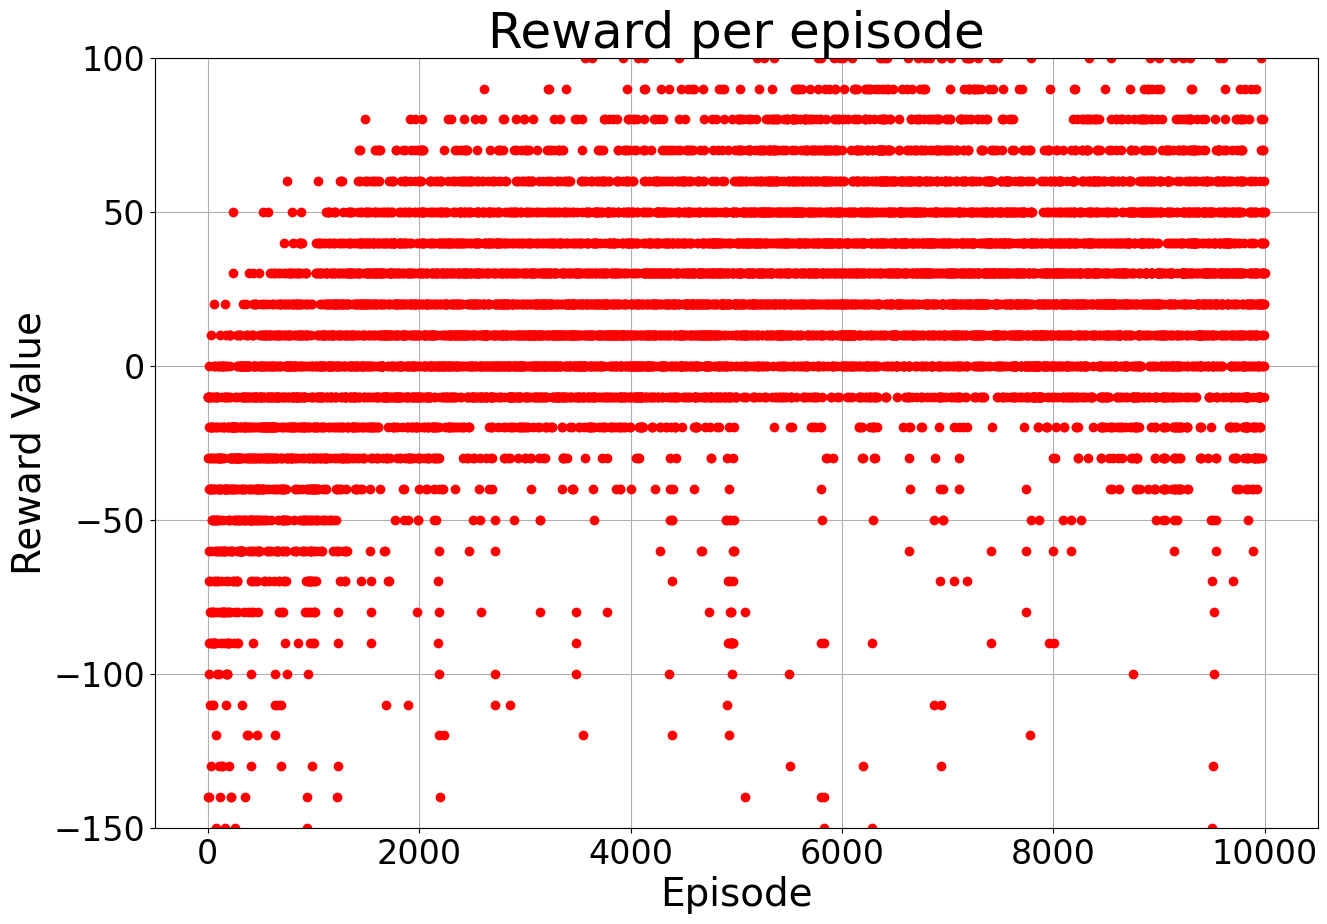

In [71]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=15, width=15, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
fifteen_complex_ddqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = torch.Tensor(transition[3])
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
              primary_theta = list(main_policy.parameters())[i].clone()
              primary_theta = torch.multiply(primary_theta, tau)
              target_theta = list(target_policy.parameters())[i].clone()
              target_theta = torch.multiply(target_theta, (1 - tau))
              list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    fifteen_complex_ddqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(fifteen_complex_ddqn_total_rewards[-100:]).mean()}')
    # End Training

plot_train_rewards(environment_name='Ten Complex', algorithm_name='Double DQN', episodic_rewards=fifteen_complex_ddqn_total_rewards, ymin=-150, ymax=100, show=True)

<Figure size 640x480 with 0 Axes>

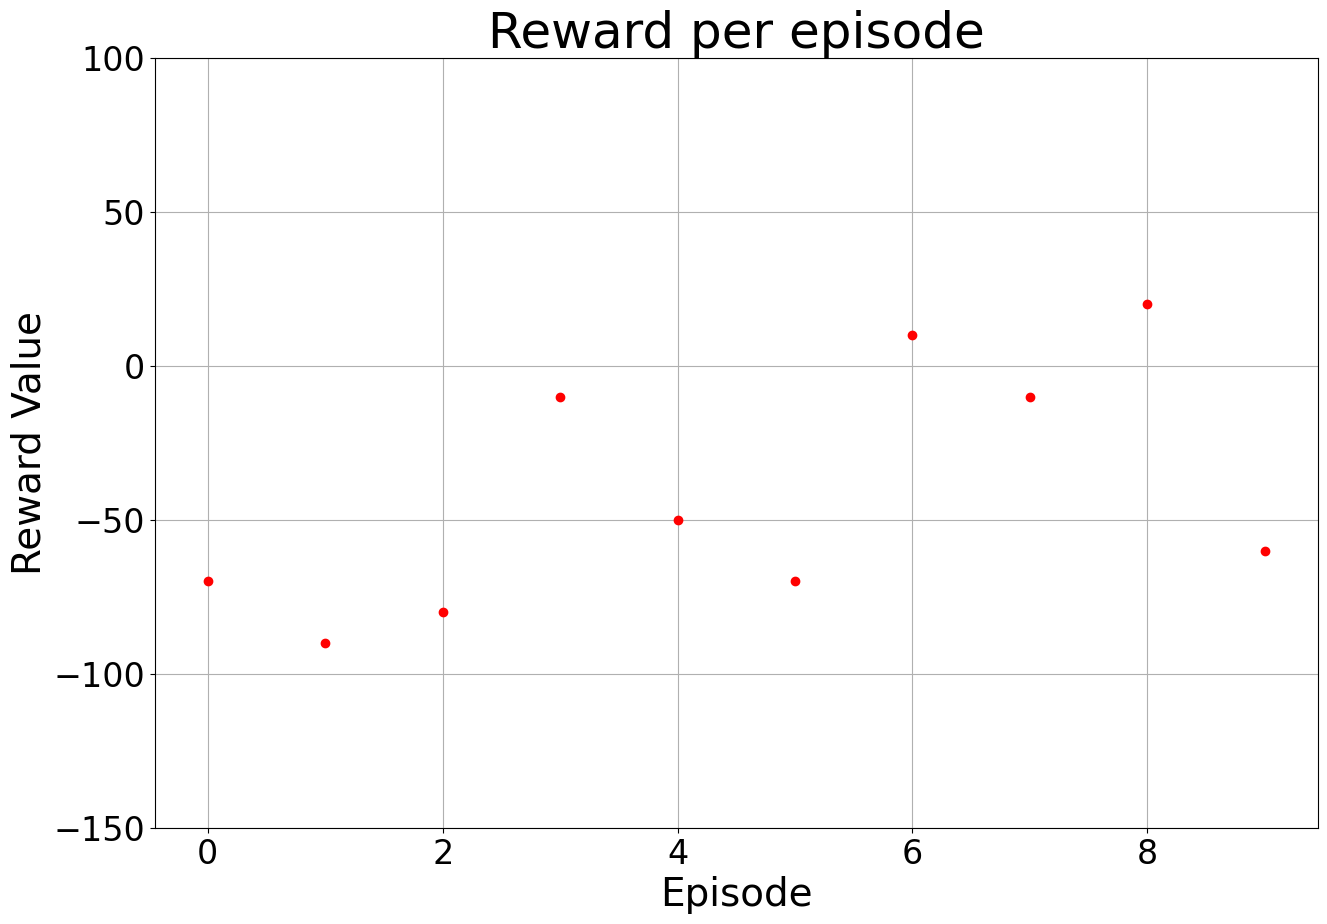

<Figure size 640x480 with 0 Axes>

In [72]:
environment_name = 'forest_fire'
algorithm_name = 'Dobule-Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
ten_complex_ddqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True, obs_type='complex')
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs

    ten_complex_ddqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, ten_complex_ddqn_test_rewards, min_reward, max_reward, show=True)

## Training the agent on complex environment with random fire

Mean reward after episode 100: -43.6
Mean reward after episode 200: -39.1
Mean reward after episode 300: -30.2
Mean reward after episode 400: -28.6
Mean reward after episode 500: -32.0
Mean reward after episode 600: -28.8
Mean reward after episode 700: -27.6
Mean reward after episode 800: -27.3
Mean reward after episode 900: -19.1
Mean reward after episode 1000: -32.6
Mean reward after episode 1100: -11.1
Mean reward after episode 1200: -11.1
Mean reward after episode 1300: -10.4
Mean reward after episode 1400: -6.4
Mean reward after episode 1500: -1.2
Mean reward after episode 1600: -18.4
Mean reward after episode 1700: -24.2
Mean reward after episode 1800: -2.2
Mean reward after episode 1900: 3.6
Mean reward after episode 2000: 3.8
Mean reward after episode 2100: 8.0
Mean reward after episode 2200: 9.0
Mean reward after episode 2300: 8.5
Mean reward after episode 2400: 3.2
Mean reward after episode 2500: 7.4
Mean reward after episode 2600: 7.5
Mean reward after episode 2700: 4.9
Mean

<Figure size 640x480 with 0 Axes>

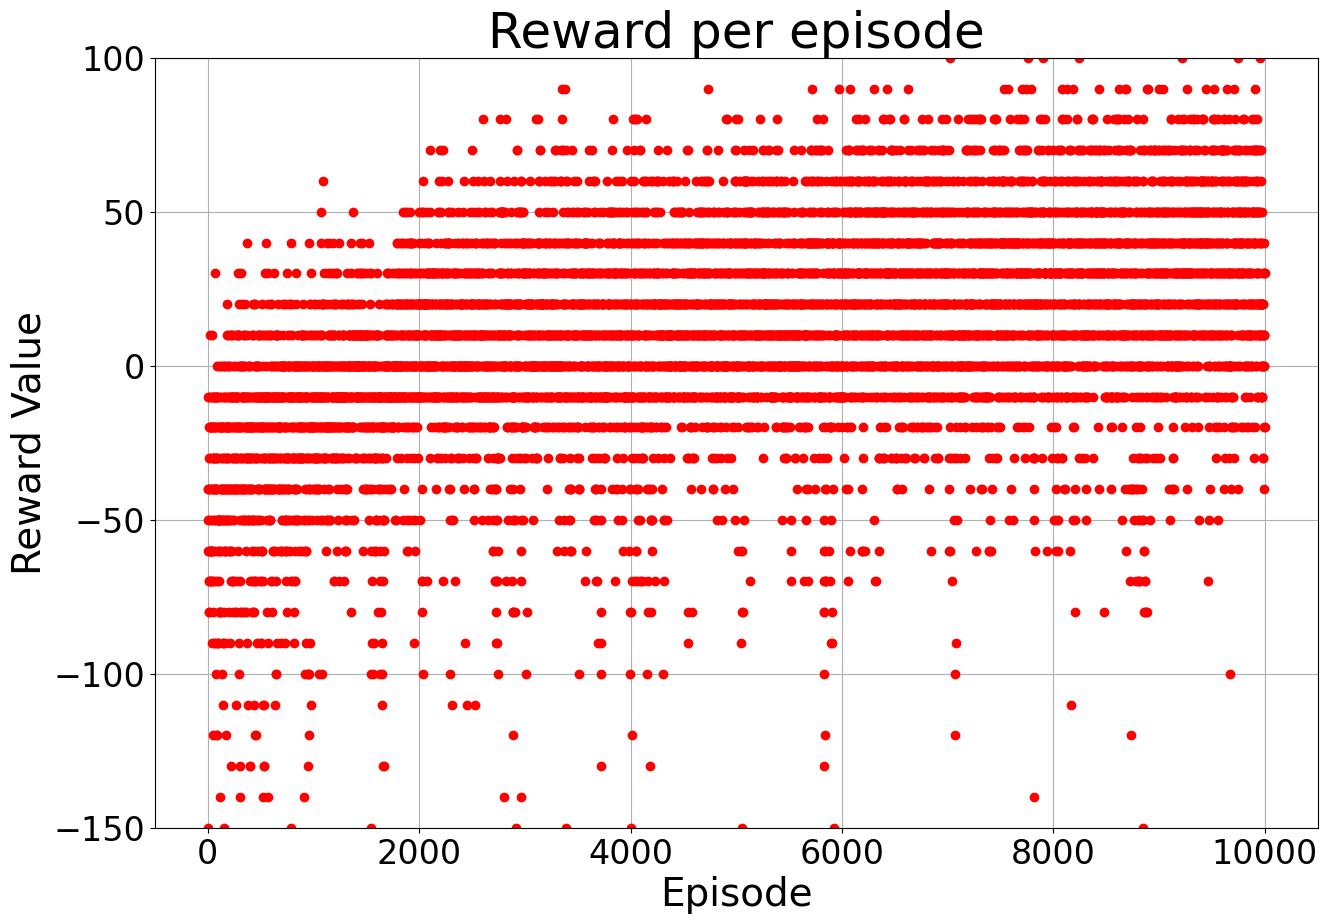

In [76]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex', random_fire=True)

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
random_fire_ddqn_total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = torch.Tensor(transition[3])
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
                primary_theta = list(main_policy.parameters())[i].clone()
                primary_theta = torch.multiply(primary_theta, tau)
                target_theta = list(target_policy.parameters())[i].clone()
                target_theta = torch.multiply(target_theta, (1 - tau))
                list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    random_fire_ddqn_total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(random_fire_ddqn_total_rewards[-100:]).mean()}')
    # End Training

plot_train_rewards(environment_name='Random Fire Complex', algorithm_name='Double DQN', episodic_rewards=random_fire_ddqn_total_rewards, ymin=-150, ymax=100, show=True)

## Testing the agent on complex environment with random fire

<Figure size 640x480 with 0 Axes>

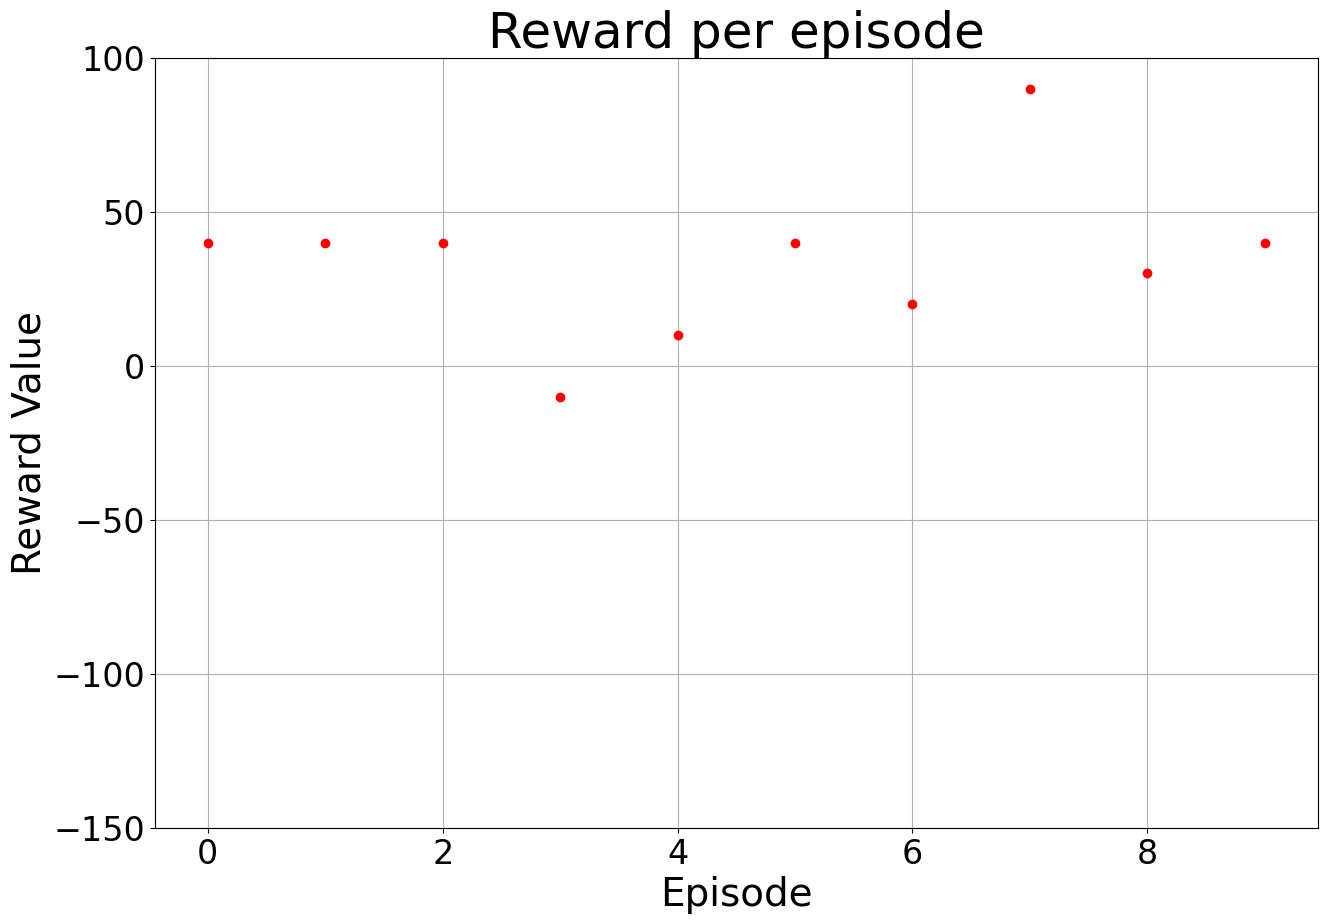

<Figure size 640x480 with 0 Axes>

In [77]:
environment_name = 'forest_fire'
algorithm_name = 'Double-Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
random_fire_ddqn_test_rewards = []
test_env = ForestFire(10, 10, save_results=True, obs_type='complex', random_fire=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs

    random_fire_ddqn_test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, random_fire_ddqn_test_rewards, min_reward, max_reward, show=True)

# Actor Critic

## Training agent on simple observation type

Mean reward after episode 0: 10.0
Mean reward after episode 100: -7.4
Mean reward after episode 200: 13.0
Mean reward after episode 300: 15.9
Mean reward after episode 400: 21.8
Mean reward after episode 500: 26.4
Mean reward after episode 600: 28.2
Mean reward after episode 700: 28.0
Mean reward after episode 800: 31.7
Mean reward after episode 900: 30.5
Mean reward after episode 1000: 28.3
Mean reward after episode 1100: 31.1
Mean reward after episode 1200: 30.0
Mean reward after episode 1300: 34.0
Mean reward after episode 1400: 28.2
Mean reward after episode 1500: 24.0
Mean reward after episode 1600: 26.5
Mean reward after episode 1700: 28.5
Mean reward after episode 1800: 26.5
Mean reward after episode 1900: 34.4


<Figure size 640x480 with 0 Axes>

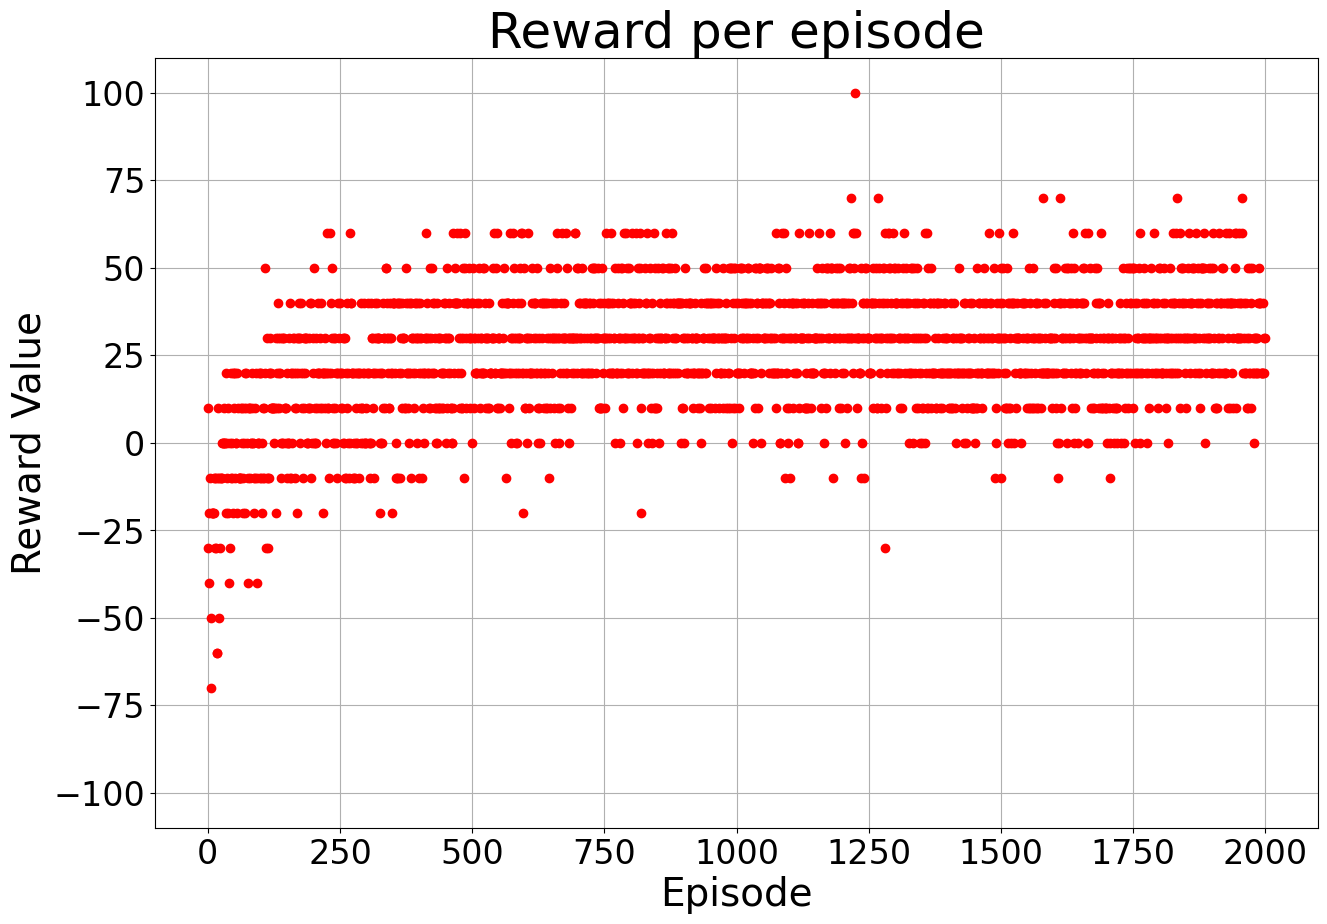

In [79]:
env = ForestFire(height=10, width=10)
actor_critic = ActorCritic(env.observation_space.shape[0], env.action_space.n, gamma=0.9, actor_lr=2e-4, critic_lr=1e-3, dense=True)
n_episodes = 2000
simple_ac_episodic_rewards = []
environment_name = 'forest_fire'
algorithm_name = 'td_ac'
min_reward = -110
max_reward = 110

# Training the agent
for i in range(n_episodes):
    obs = env.reset()
    done = False
    reward = 0
    while not done:
        action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
        new_obs, rew, done = env.step(action)
        reward += rew
        actor_critic.learn(
            torch.from_numpy(obs).float().unsqueeze(0),
            action,
            log_probability,
            rew,
            torch.from_numpy(new_obs).float().unsqueeze(0),
            done
        )
        obs = new_obs

    simple_ac_episodic_rewards.append(reward)
    if(np.all(np.array(simple_ac_episodic_rewards[-10:]) >= 100)):
        break
    if(i%100 == 0):
        print(f'Mean reward after episode {i}: {np.array(simple_ac_episodic_rewards[-100:]).mean()}')


plot_train_rewards(environment_name, algorithm_name, simple_ac_episodic_rewards, min_reward, max_reward, show=True)

## Testing agent on simple observation type

<Figure size 640x480 with 0 Axes>

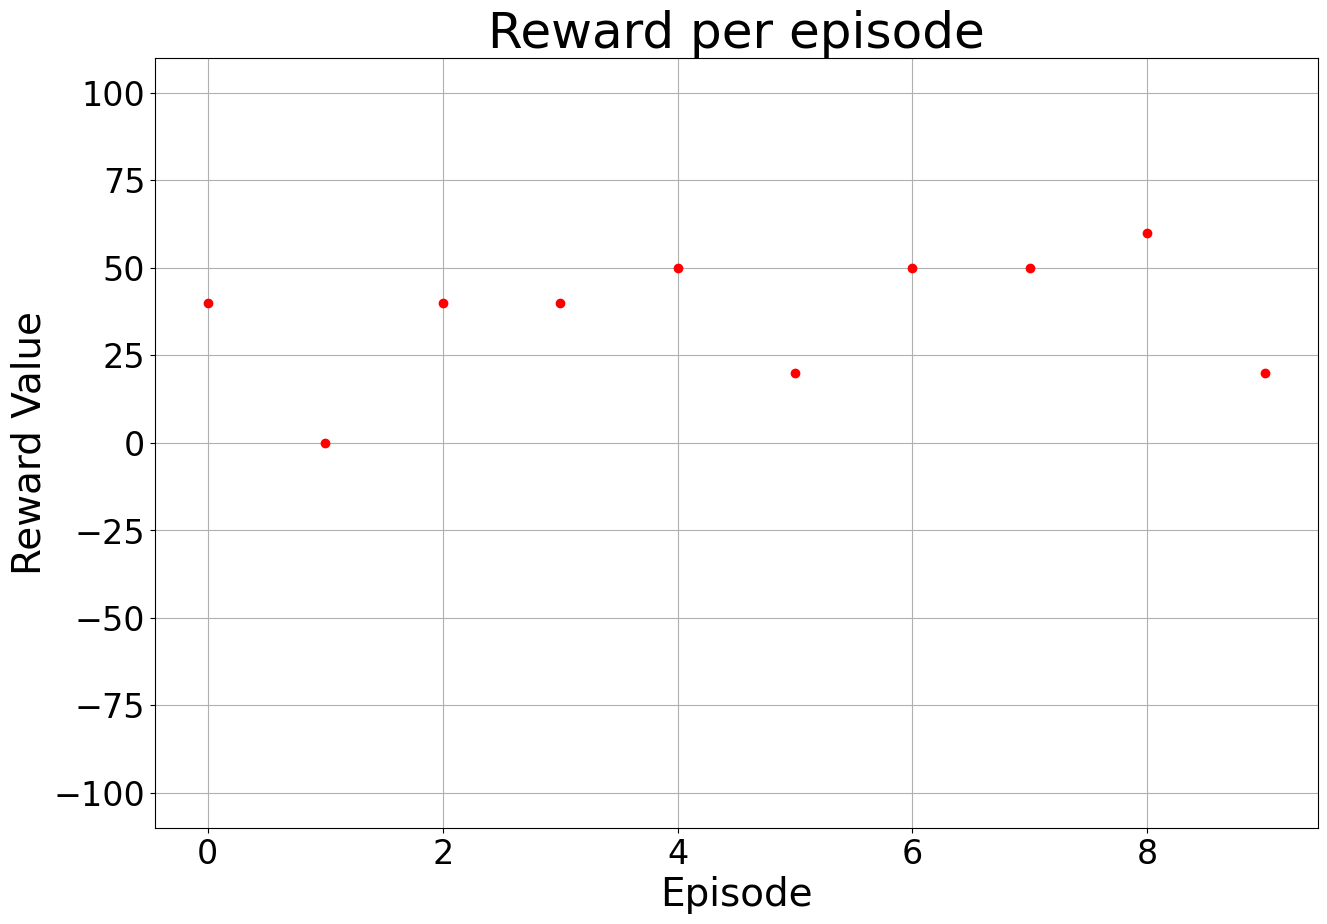

<Figure size 640x480 with 0 Axes>

In [80]:
n_episodes_test = 10
test_rewards = []
test_env = ForestFire(height=10, width=10, save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
#     render = test_env.render(plot=False)
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
#             render = test_env.render(plot=False)
#     print(reward)
    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

## Training agent on complex observation type

Mean reward after episode 0: -40.0
Mean reward after episode 100: -6.2
Mean reward after episode 200: 15.0
Mean reward after episode 300: 33.4
Mean reward after episode 400: 44.7
Mean reward after episode 500: 46.5
Mean reward after episode 600: 49.5
Mean reward after episode 700: 53.4
Mean reward after episode 800: 51.3
Mean reward after episode 900: 51.8
Mean reward after episode 1000: 58.0
Mean reward after episode 1100: 57.5
Mean reward after episode 1200: 55.4
Mean reward after episode 1300: 51.4
Mean reward after episode 1400: 51.5
Mean reward after episode 1500: 54.9
Mean reward after episode 1600: 53.3
Mean reward after episode 1700: 54.0
Mean reward after episode 1800: 54.6
Mean reward after episode 1900: 58.5
Mean reward after episode 2000: 55.1
Mean reward after episode 2100: 55.0
Mean reward after episode 2200: 55.7
Mean reward after episode 2300: 54.1
Mean reward after episode 2400: 58.6
Mean reward after episode 2500: 61.8
Mean reward after episode 2600: 52.8
Mean reward 

<Figure size 640x480 with 0 Axes>

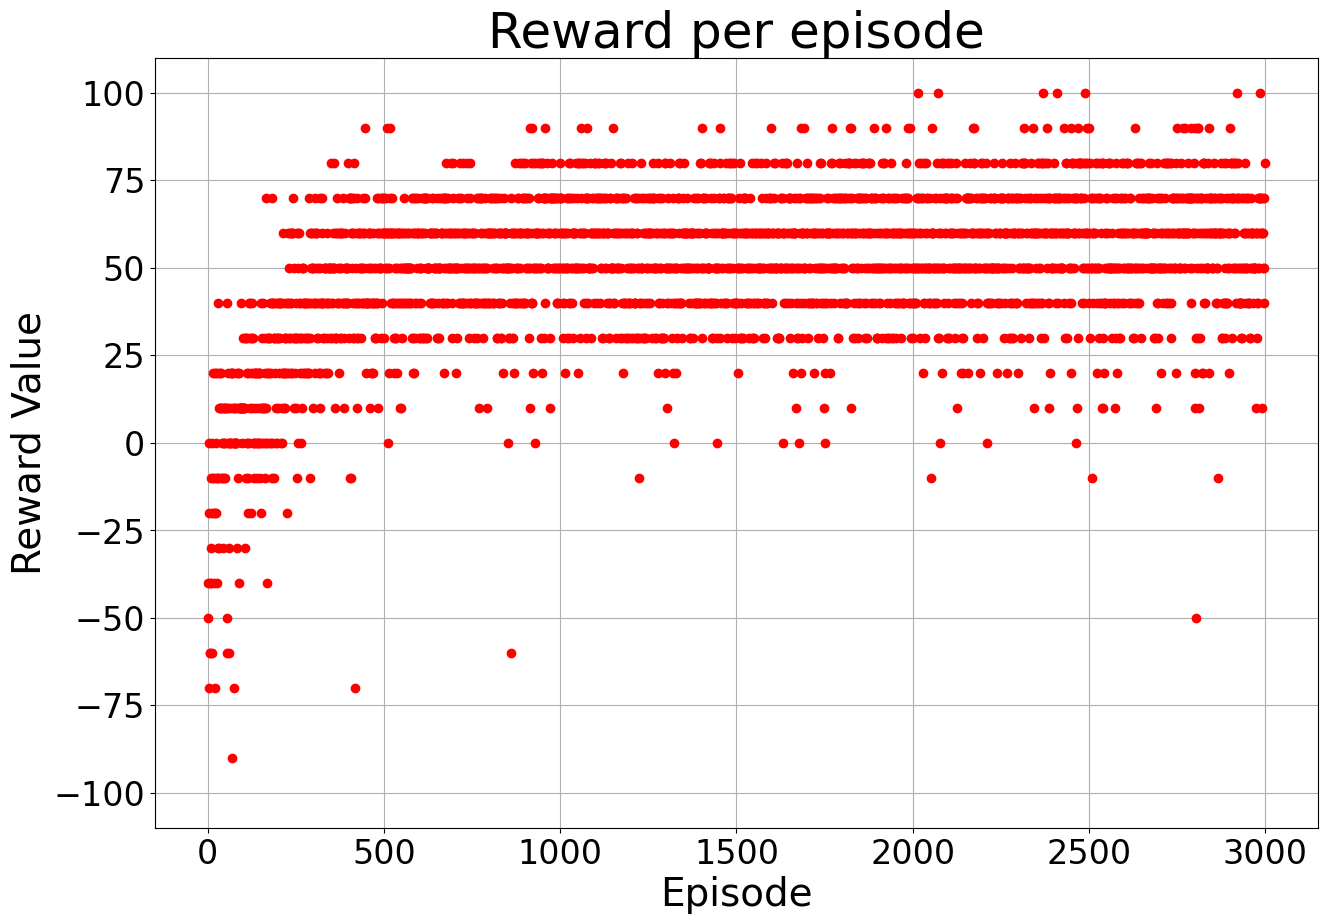

In [81]:
env = ForestFire(height=10, width=10, obs_type='complex')
actor_critic = ActorCritic(env.observation_space.shape[0], env.action_space.n, gamma=0.9, actor_lr=2e-4, critic_lr=1e-3, dense=True)
n_episodes = 3000
complex_ac_episodic_rewards = []
environment_name = 'forest_fire_complex'
algorithm_name = 'td_ac'
min_reward = -110
max_reward = 110

# Training the agent
for i in range(n_episodes):
    obs = env.reset()
    done = False
    reward = 0
    while not done:
        action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
        new_obs, rew, done = env.step(action)
        reward += rew
        actor_critic.learn(
            torch.from_numpy(obs).float().unsqueeze(0),
            action,
            log_probability,
            rew,
            torch.from_numpy(new_obs).float().unsqueeze(0),
            done
        )
        obs = new_obs

    complex_ac_episodic_rewards.append(reward)
    if(np.all(np.array(complex_ac_episodic_rewards[-10:]) >= 100)):
        break
    if(i%100 == 0):
        print(f'Mean reward after episode {i}: {np.array(complex_ac_episodic_rewards[-100:]).mean()}')


plot_train_rewards(environment_name, algorithm_name, complex_ac_episodic_rewards, min_reward, max_reward, show=True)

## Testing agent on complex observation type

<Figure size 640x480 with 0 Axes>

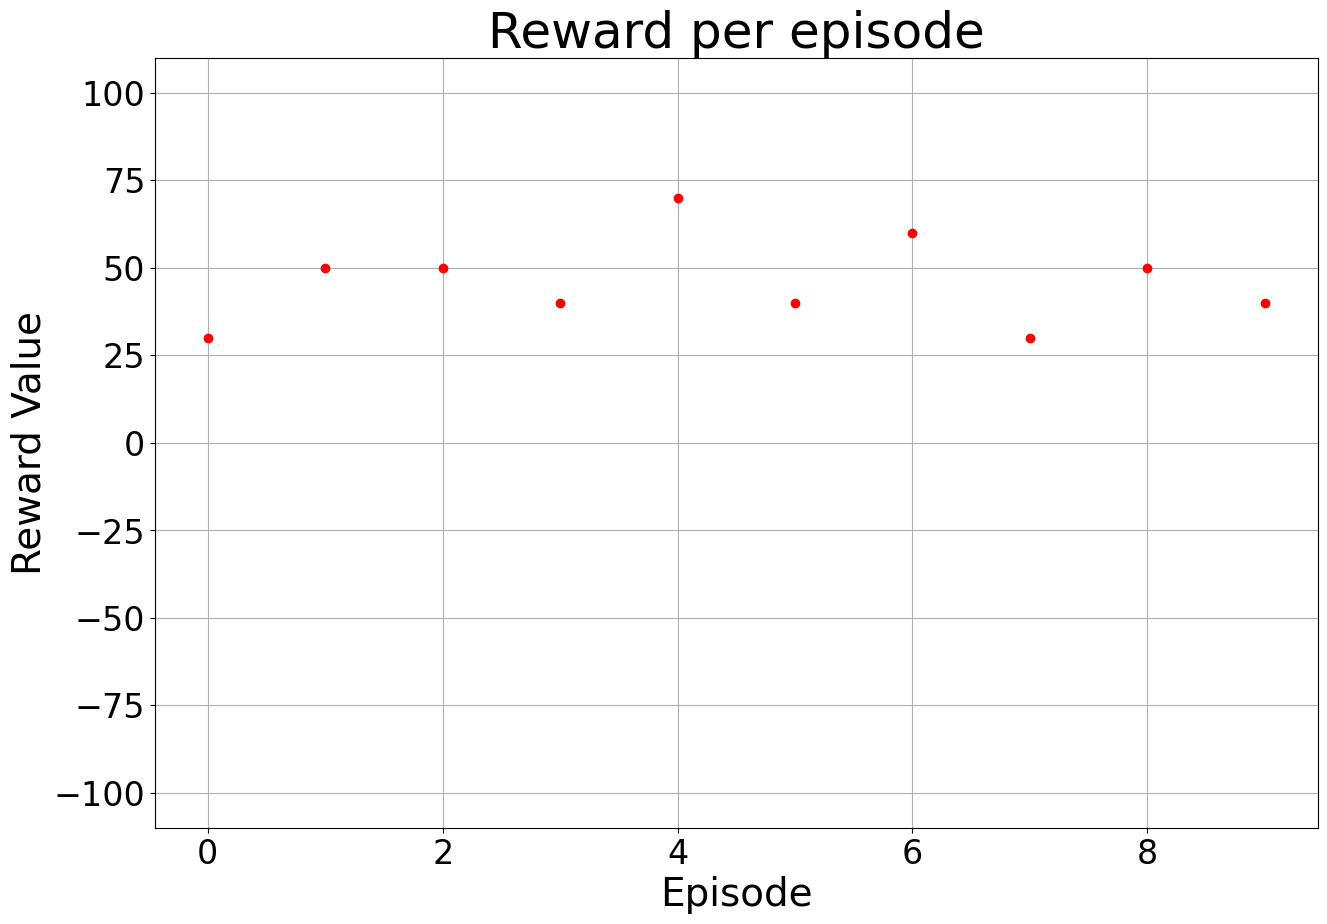

<Figure size 640x480 with 0 Axes>

In [82]:
n_episodes_test = 10
test_rewards = []
test_env = ForestFire(height=10, width=10, obs_type='complex', save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
#     render = test_env.render(plot=False)
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
#             render = test_env.render(plot=False)
#     print(reward)
    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

## Testing the above trained agent on 15x15 environment size

<Figure size 640x480 with 0 Axes>

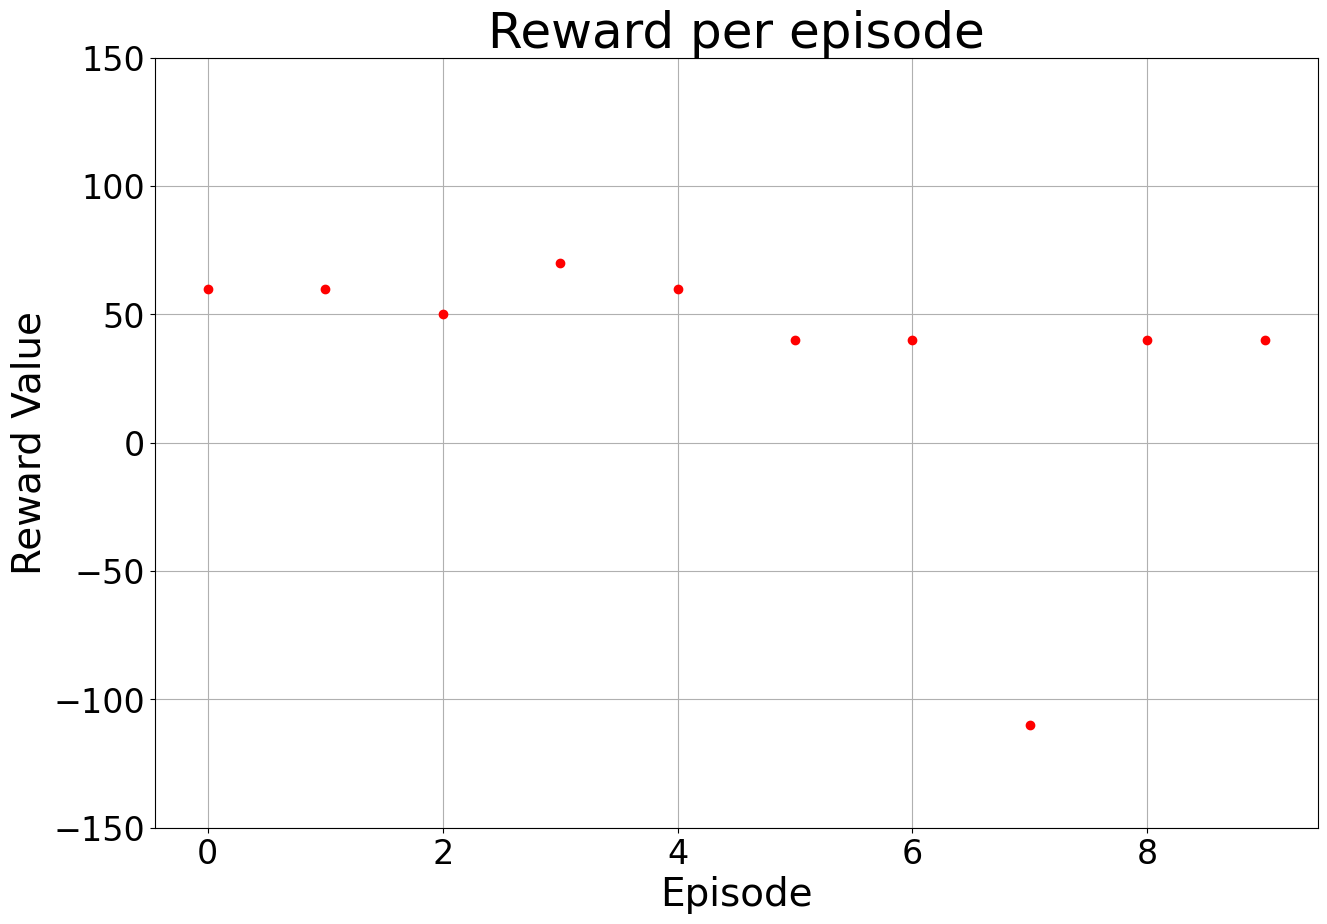

<Figure size 640x480 with 0 Axes>

In [83]:
n_episodes_test = 10
test_rewards = []
env = ForestFire(height=15, width=15, obs_type='complex')
min_reward = -150
max_reward = 150
for i in range(n_episodes_test):
    obs = env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = env.step(action)
            reward += rew
            obs = new_obs

    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

## Training the agent on 15x15 environment size

Mean reward after episode 0: -140.0
Mean reward after episode 100: 2.6
Mean reward after episode 200: 10.0
Mean reward after episode 300: 17.1
Mean reward after episode 400: 33.4
Mean reward after episode 500: 39.5
Mean reward after episode 600: 45.6
Mean reward after episode 700: 49.2
Mean reward after episode 800: 48.0
Mean reward after episode 900: 51.3
Mean reward after episode 1000: 55.9
Mean reward after episode 1100: 53.9
Mean reward after episode 1200: 52.7
Mean reward after episode 1300: 49.9
Mean reward after episode 1400: 52.9
Mean reward after episode 1500: 59.6
Mean reward after episode 1600: 52.7
Mean reward after episode 1700: 57.9
Mean reward after episode 1800: 62.4
Mean reward after episode 1900: 55.2
Mean reward after episode 2000: 61.5
Mean reward after episode 2100: 50.7
Mean reward after episode 2200: 61.2
Mean reward after episode 2300: 57.3
Mean reward after episode 2400: 52.6
Mean reward after episode 2500: 59.9
Mean reward after episode 2600: 58.6
Mean reward 

<Figure size 640x480 with 0 Axes>

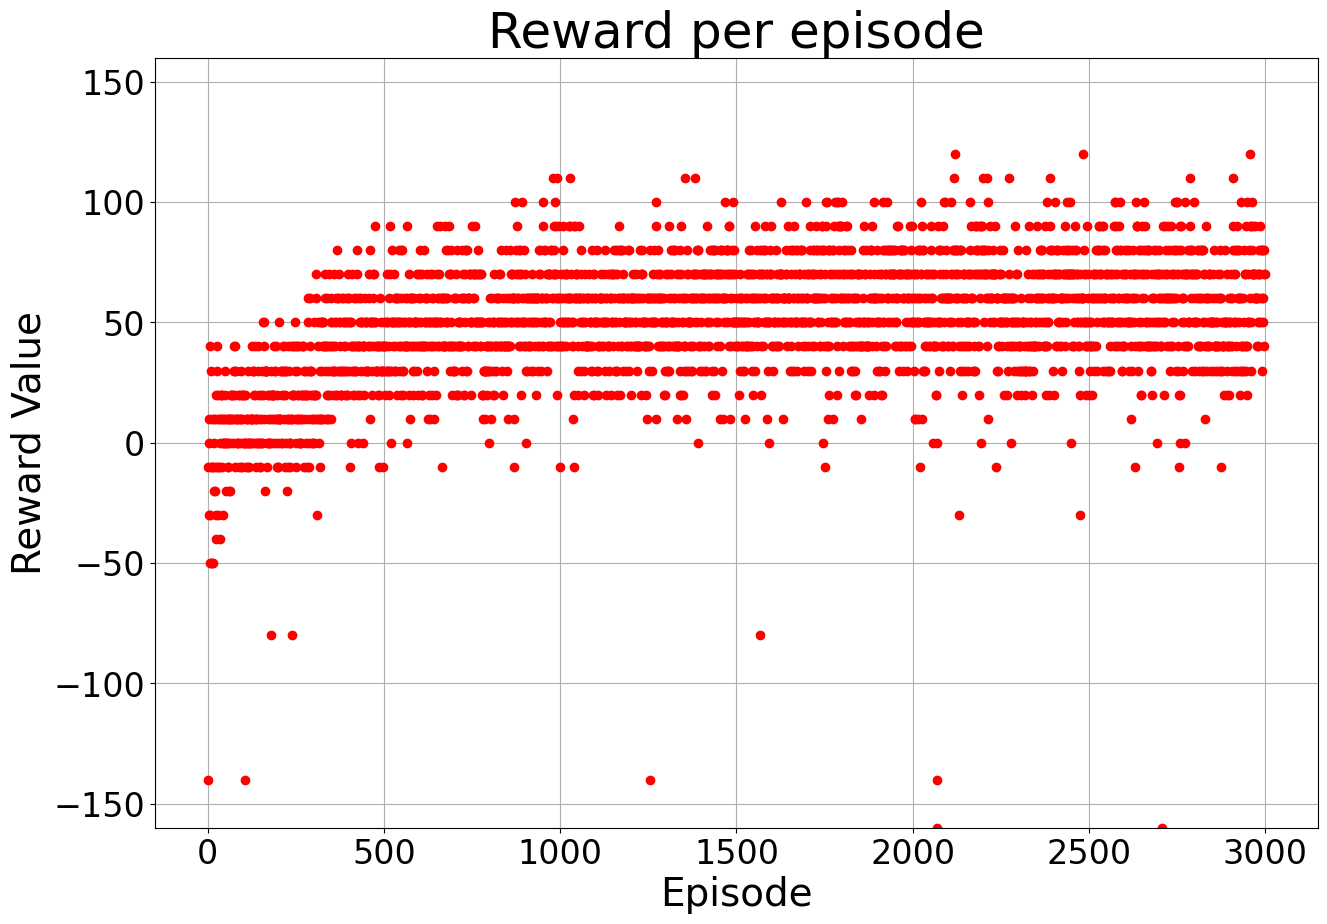

In [85]:
env = ForestFire(height=15, width=15, obs_type='complex')
actor_critic = ActorCritic(env.observation_space.shape[0], env.action_space.n, gamma=0.9, actor_lr=2e-4, critic_lr=1e-3, dense=True)
n_episodes = 3000
episodic_rewards = []
environment_name = 'forest_fire_complex'
algorithm_name = 'td_ac'
min_reward = -160
max_reward = 160

# Training the agent
for i in range(n_episodes):
    obs = env.reset()
    done = False
    reward = 0
    while not done:
        action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
        new_obs, rew, done = env.step(action)
        reward += rew
        actor_critic.learn(
            torch.from_numpy(obs).float().unsqueeze(0),
            action,
            log_probability,
            rew,
            torch.from_numpy(new_obs).float().unsqueeze(0),
            done
        )
        obs = new_obs

    episodic_rewards.append(reward)
    if(np.all(np.array(episodic_rewards[-10:]) >= 100)):
        break
    if(i%100 == 0):
        print(f'Mean reward after episode {i}: {np.array(episodic_rewards[-100:]).mean()}')


plot_train_rewards(environment_name, algorithm_name, episodic_rewards, min_reward, max_reward, show=True)

## Testing the above trained agent on 10x10 environment size

<Figure size 640x480 with 0 Axes>

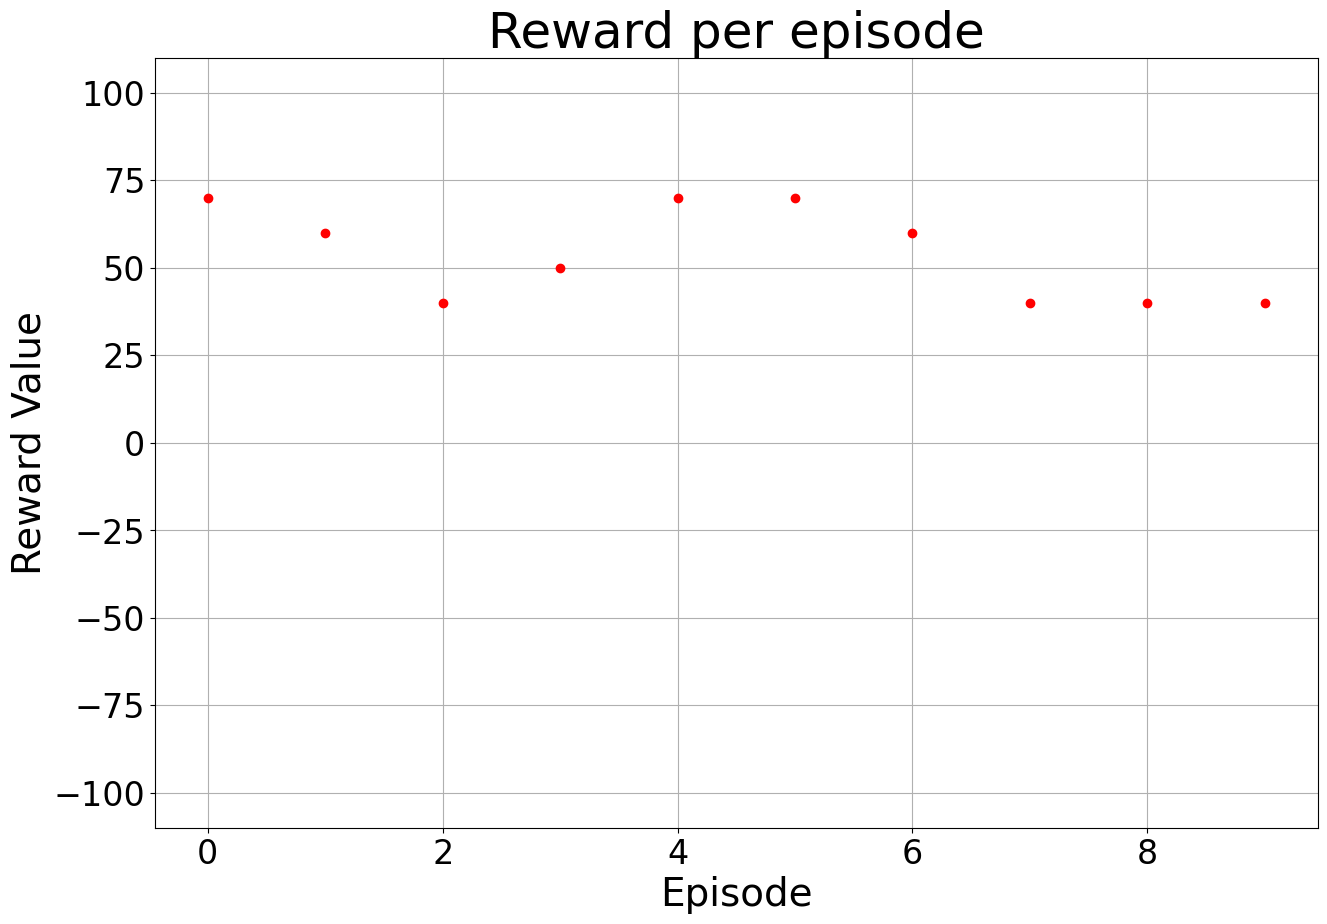

<Figure size 640x480 with 0 Axes>

In [86]:
n_episodes_test = 10
test_rewards = []
env = ForestFire(height=10, width=10, obs_type='complex')
min_reward = -110
max_reward = 110
for i in range(n_episodes_test):
    obs = env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = env.step(action)
            reward += rew
            obs = new_obs

    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

## Training the agent on random fire initialization environment

Mean reward after episode 0: -20.0
Mean reward after episode 100: -16.9
Mean reward after episode 200: -1.7
Mean reward after episode 300: 1.2
Mean reward after episode 400: 7.9
Mean reward after episode 500: 12.1
Mean reward after episode 600: 17.9
Mean reward after episode 700: 17.2
Mean reward after episode 800: 20.4
Mean reward after episode 900: 21.8
Mean reward after episode 1000: 27.7
Mean reward after episode 1100: 20.3
Mean reward after episode 1200: 27.5
Mean reward after episode 1300: 33.9
Mean reward after episode 1400: 29.7
Mean reward after episode 1500: 30.3
Mean reward after episode 1600: 40.4
Mean reward after episode 1700: 38.3
Mean reward after episode 1800: 41.3
Mean reward after episode 1900: 41.7
Mean reward after episode 2000: 43.8
Mean reward after episode 2100: 49.4
Mean reward after episode 2200: 51.2
Mean reward after episode 2300: 51.3
Mean reward after episode 2400: 53.8
Mean reward after episode 2500: 43.5
Mean reward after episode 2600: 48.1
Mean reward a

<Figure size 640x480 with 0 Axes>

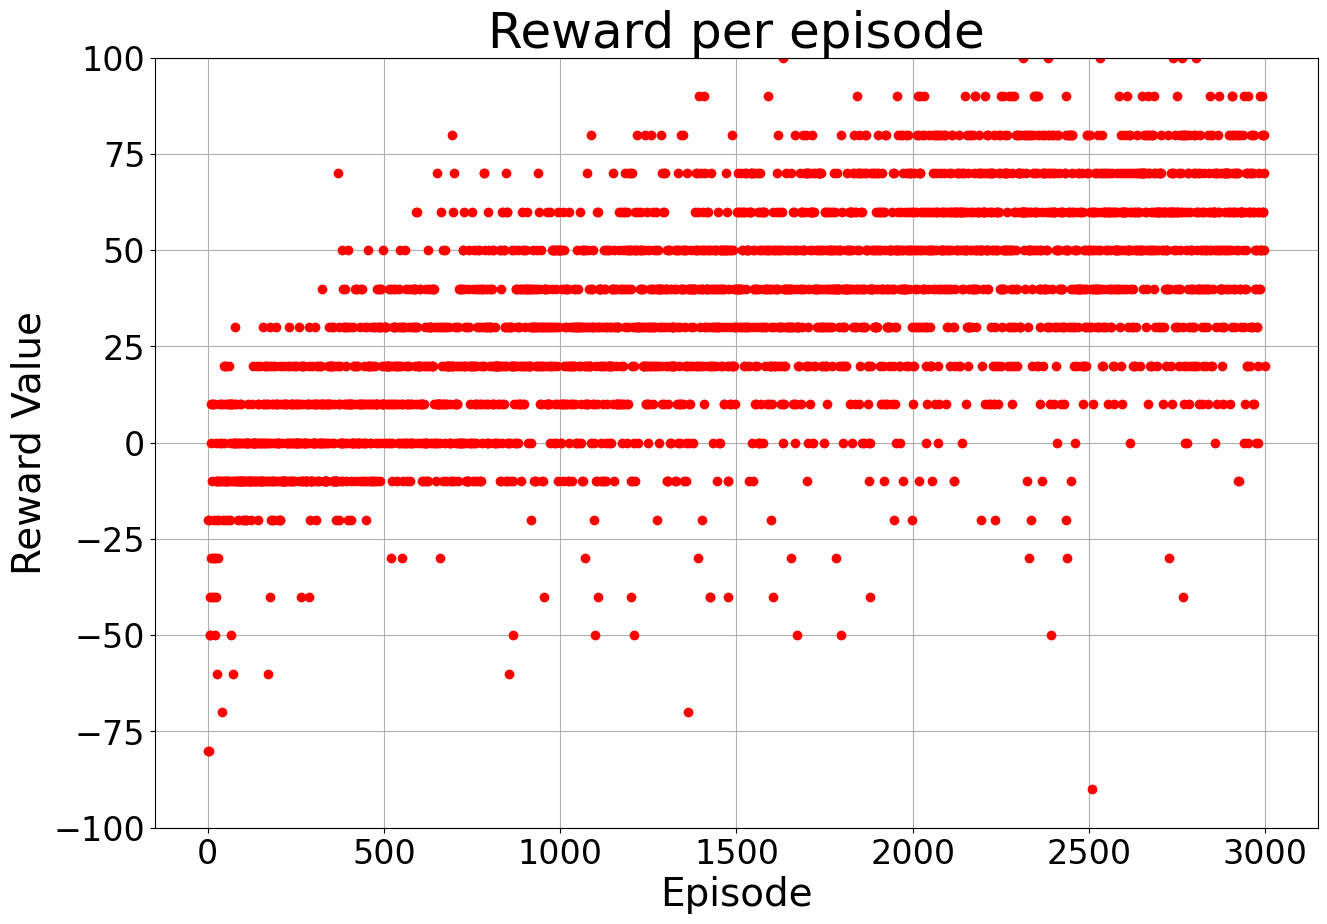

In [88]:
env = ForestFire(height=10, width=10, obs_type='complex', random_fire=True)
actor_critic = ActorCritic(env.observation_space.shape[0], env.action_space.n, gamma=0.9, actor_lr=2e-4, critic_lr=1e-3, dense=True)
n_episodes = 3000
complex_random_ac_episodic_rewards = []
environment_name = 'forest_fire_complex_random_fire'
algorithm_name = 'td_ac'
min_reward = -100
max_reward = 100

# Training the agent
for i in range(n_episodes):
    obs = env.reset()
    done = False
    reward = 0
    while not done:
        action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
        new_obs, rew, done = env.step(action)
        reward += rew
        actor_critic.learn(
            torch.from_numpy(obs).float().unsqueeze(0),
            action,
            log_probability,
            rew,
            torch.from_numpy(new_obs).float().unsqueeze(0),
            done
        )
        obs = new_obs

    complex_random_ac_episodic_rewards.append(reward)
    if(np.all(np.array(complex_random_ac_episodic_rewards[-10:]) >= 100)):
        break
    if(i%100 == 0):
        print(f'Mean reward after episode {i}: {np.array(complex_random_ac_episodic_rewards[-100:]).mean()}')


plot_train_rewards(environment_name, algorithm_name, complex_random_ac_episodic_rewards, min_reward, max_reward, show=True)

## Testing the agent on random fire initialization environment

<Figure size 640x480 with 0 Axes>

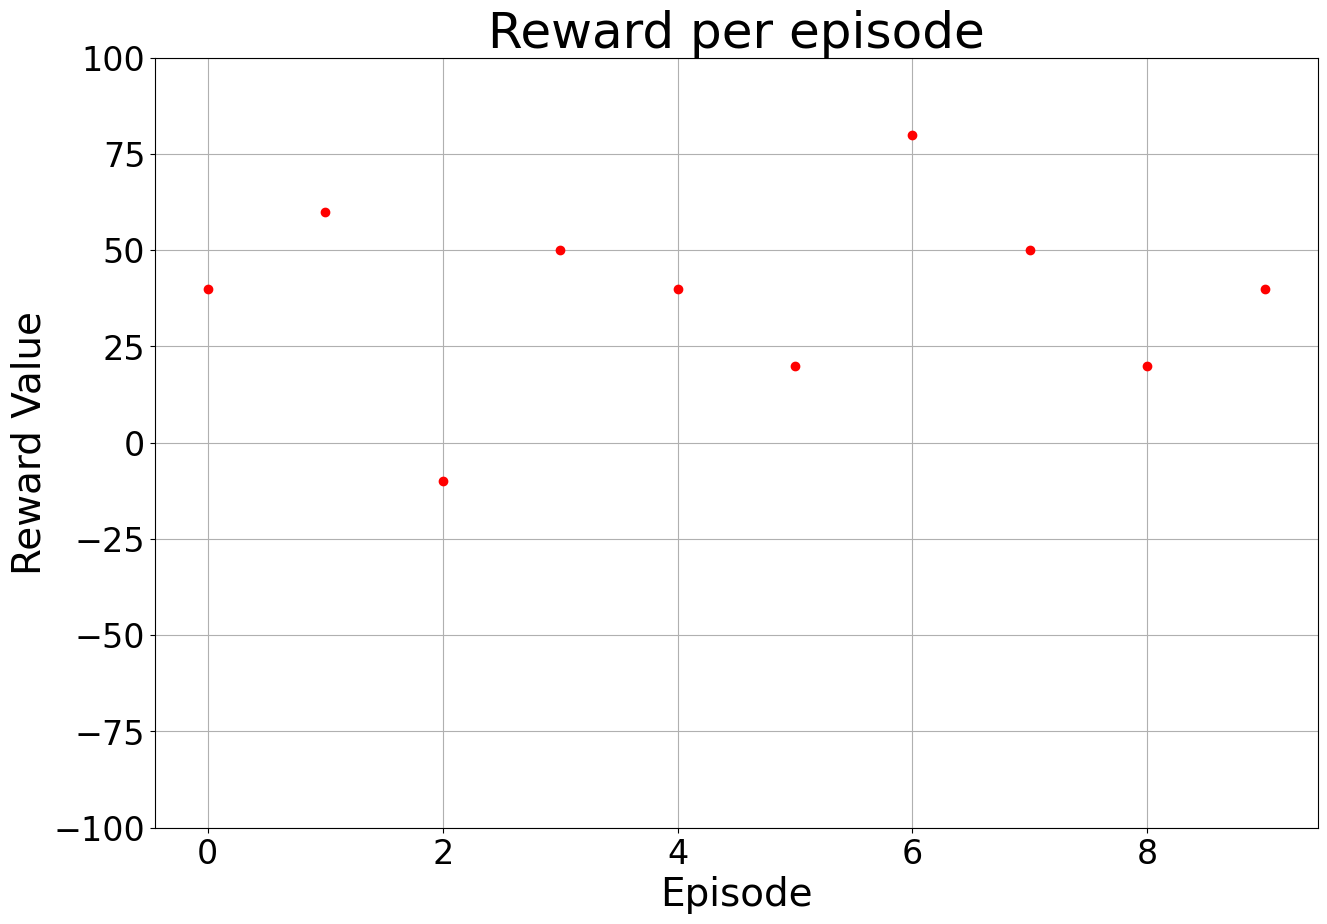

<Figure size 640x480 with 0 Axes>

In [89]:
n_episodes_test = 10
test_rewards = []
test_env = ForestFire(height=10, width=10, obs_type='complex', random_fire=True, save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
#     render = test_env.render(plot=False)
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
#             render = test_env.render(plot=False)
#     print(reward)
    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

# Plotting combined graphs

In [90]:
# Function to compact lists if needed and convert them to numpy arrays.
def compact_and_convert(list_):
    list_len = len(list_)
    new_list = np.array(list_)
    new_list = np.reshape(new_list, (1000, list_len//1000))
    new_list = np.mean(new_list, axis=1)
    return new_list

In [91]:
# Resizing lists to 1000 length
np_simple_dqn_total_rewards = compact_and_convert(simple_dqn_total_rewards)
np_simple_ddqn_total_rewards = compact_and_convert(simple_ddqn_total_rewards)
np_simple_ac_episodic_rewards = compact_and_convert(simple_ac_episodic_rewards)
np_complex_dqn_total_rewards = compact_and_convert(complex_dqn_total_rewards)
np_complex_ddqn_total_rewards = compact_and_convert(complex_ddqn_total_rewards)
np_complex_ac_episodic_rewards = compact_and_convert(complex_ac_episodic_rewards)
np_random_fire_dqn_total_rewards = compact_and_convert(random_fire_dqn_total_rewards)
np_random_fire_ddqn_total_rewards = compact_and_convert(random_fire_ddqn_total_rewards)
np_complex_random_ac_episodic_rewards = compact_and_convert(complex_random_ac_episodic_rewards)

In [92]:
# Code for plotting inspired from https://www.reddit.com/r/reinforcementlearning/comments/gnvlcp/way_to_plot_goodlooking_rewards_plots/

def plot_graph(data_list, title, colors=["red", "black", "green"], labels=["DQN", "DDQN","Actor Critic"]):
    min_len = 1000
    sns.set_style("whitegrid", {'axes.grid' : True, 'axes.edgecolor':'black'})
    fig = plt.figure()
    plt.clf()
    ax = fig.gca()
    color_patch = []
    for color, label, data in zip(colors, labels, data_list):
        sns.lineplot(data=data, color=color, ci=95)
        color_patch.append(mpatches.Patch(color=color, label=label))
    plt.xlim([0, min_len])
    plt.xlabel('Training Epochs', fontsize=22)
    plt.ylabel('Return', fontsize=22)
    lgd=plt.legend(
    frameon=True, fancybox=True, \
    prop={'weight':'bold', 'size':14}, handles=color_patch, loc="best")
    plt.title(title, fontsize=14)
    ax = plt.gca()
    plt.setp(ax.get_yticklabels(), fontsize=16)
    sns.despine()
    plt.tight_layout()
    plt.show()

C:\Users\John\AppData\Local\Temp\ipykernel_14268\3999201323.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, color=color, ci=95)
C:\Users\John\AppData\Local\Temp\ipykernel_14268\3999201323.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, color=color, ci=95)
C:\Users\John\AppData\Local\Temp\ipykernel_14268\3999201323.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, color=color, ci=95)


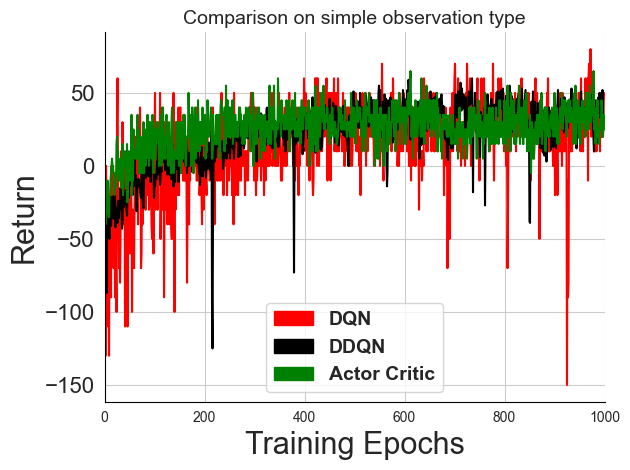

In [93]:
plot_graph([np_simple_dqn_total_rewards, np_simple_ddqn_total_rewards, np_simple_ac_episodic_rewards], title='Comparison on simple observation type')

C:\Users\John\AppData\Local\Temp\ipykernel_14268\3999201323.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, color=color, ci=95)
C:\Users\John\AppData\Local\Temp\ipykernel_14268\3999201323.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, color=color, ci=95)
C:\Users\John\AppData\Local\Temp\ipykernel_14268\3999201323.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, color=color, ci=95)


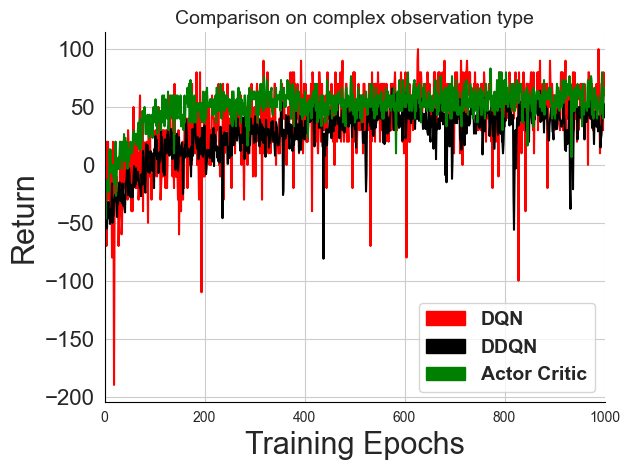

In [94]:
plot_graph([np_complex_dqn_total_rewards, np_complex_ddqn_total_rewards, np_complex_ac_episodic_rewards], title='Comparison on complex observation type')

C:\Users\John\AppData\Local\Temp\ipykernel_14268\3999201323.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, color=color, ci=95)
C:\Users\John\AppData\Local\Temp\ipykernel_14268\3999201323.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, color=color, ci=95)
C:\Users\John\AppData\Local\Temp\ipykernel_14268\3999201323.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, color=color, ci=95)


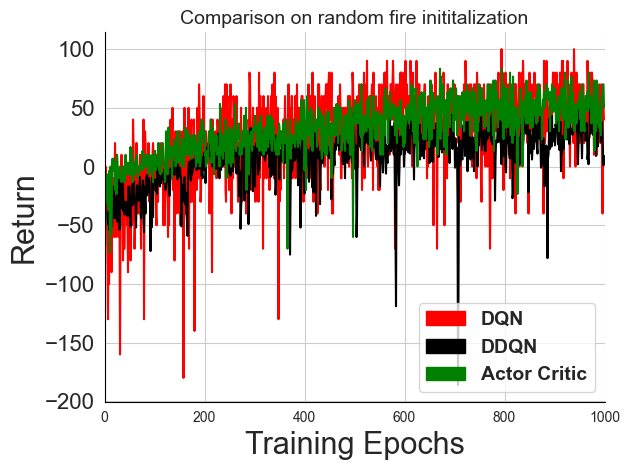

In [95]:
plot_graph([np_random_fire_dqn_total_rewards, np_random_fire_ddqn_total_rewards, np_complex_random_ac_episodic_rewards], title='Comparison on random fire inititalization')

C:\Users\John\AppData\Local\Temp\ipykernel_14268\3999201323.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, color=color, ci=95)
C:\Users\John\AppData\Local\Temp\ipykernel_14268\3999201323.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, color=color, ci=95)


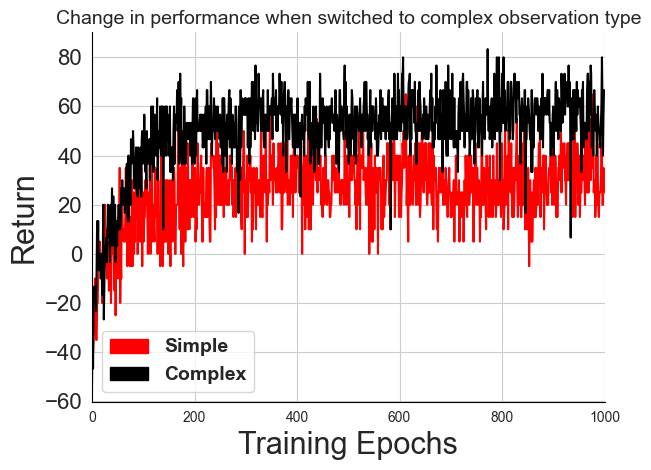

In [96]:
# Graph to show improvement achieved when complex observation type is used
plot_graph([np_simple_ac_episodic_rewards, np_complex_ac_episodic_rewards], title='Change in performance when switched to complex observation type', labels=['Simple', 'Complex'])